In [58]:
library(BiocManager)
library(GOSemSim)
library(biomaRt)
library(data.table)
library(pheatmap)
library(tidyverse)

In [2]:
human <- readRDS("/data/timonaj/biomart_orthologs/human.RDS")

In [3]:
human_attr <- listAttributes(human)
human_attr[grep("entrez", human_attr$name),]

,name,description,page
,<chr>,<chr>,<chr>
60,entrezgene_trans_name,EntrezGene transcript name ID,feature_page
80,entrezgene_description,NCBI gene (formerly Entrezgene) description,feature_page
81,entrezgene_accession,NCBI gene (formerly Entrezgene) accession,feature_page
82,entrezgene_id,NCBI gene (formerly Entrezgene) ID,feature_page


In [4]:
get_reccurent_genes <- function(duplicated_list,species_exptype,total_exps,title) {
    print(paste(species_exptype,title, sep =" "))
    
    if(total_exps == 1) {
        print(paste(species_exptype, "total_datasets :", total_exps, sep =" "))
        print("################################################")
        return(duplicated_list)
    }
    
    duplicated_list <- sort(table(duplicated_list), decreasing = TRUE)
    
    if(length(duplicated_list) > 1000) {
        duplicated_list <- duplicated_list[1:1000]
    }
    
    duplicated_list <- duplicated_list[duplicated_list > 2]
    
    print(paste(species_exptype, "total_datasets :", total_exps, sep =" "))
    print(paste(species_exptype, "mean reccurence :", mean(duplicated_list), sep =" "))
    print(paste(species_exptype, "min reccurence :", min(duplicated_list), sep =" "))
    print(paste(species_exptype, "max reccurence :", max(duplicated_list), sep =" "))
    print("################################################")
    return(names(duplicated_list))
}

wrs_list <- list("upregulated" = list(),
                 "downregulated" = list())
recurrent_wrs_list <- list("upregulated" = list(),
                           "downregulated" = list())


wrs_files <-list.files('./geo_degs/')
wrs_foi <- wrs_files[grep("^[a-z].*", wrs_files)]
species_exptype <- unique(sub('_[A-Z].*$', '',wrs_foi))

wrs_foi_up <- wrs_files[grep("^[a-z].*upregulated.*", wrs_files)]
wrs_foi_down <- wrs_files[grep("^[a-z].*downregulated.*", wrs_files)]

for(i in 1:length(species_exptype)) {
    
    current_species_up <- wrs_foi_up[grep(species_exptype[i], wrs_foi_up)]
    current_species_down <- wrs_foi_down[grep(species_exptype[i], wrs_foi_down)]
    total_spec_exp_up <- character(0)
    total_spec_exp_down <- character(0)
    
    if(length(current_species_up) == length(current_species_down)) {
        for(j in 1:length(current_species_up)) {
            current_file_path_up <- paste('./geo_degs/', current_species_up[j], sep="")
            current_file_path_down <- paste('./geo_degs/', current_species_down[j], sep="")
            
            total_genes_up <- fread(current_file_path_up, header=FALSE)$V1
            total_genes_down <- fread(current_file_path_down, header=FALSE)$V1
            
            mapping_up <- getLDS(attributes=c("hgnc_symbol"), filters="hgnc_symbol",
                        values=total_genes_up,
                        mart=human,attributesL=c("hgnc_symbol","entrezgene_id"),
                        martL=human)
            mapping_down <- getLDS(attributes=c("hgnc_symbol"), filters="hgnc_symbol",
                        values=total_genes_down,
                        mart=human,attributesL=c("hgnc_symbol","entrezgene_id"),
                        martL=human)
            
            total_spec_exp_up <- append(total_spec_exp_up,
                                        unique(mapping_up[,"NCBI.gene..formerly.Entrezgene..ID"]),
                                        length(total_spec_exp_up))
            total_spec_exp_down <- append(total_spec_exp_down,
                                          unique(mapping_down[,"NCBI.gene..formerly.Entrezgene..ID"]),
                                          length(total_spec_exp_down))
        }
    }
    # union of all genes
    wrs_list[["upregulated"]][[species_exptype[i]]] <- unique(total_spec_exp_up)
    wrs_list[["downregulated"]][[species_exptype[i]]] <- unique(total_spec_exp_down)
    
    # top recurrent genes
    recurrent_wrs_list[["upregulated"]][[species_exptype[i]]] <- get_reccurent_genes(total_spec_exp_up,
                                                                                     species_exptype[i],
                                                                                     length(current_species_up),
                                                                                     "upregulated")
    recurrent_wrs_list[["downregulated"]][[species_exptype[i]]] <- get_reccurent_genes(total_spec_exp_down,
                                                                                       species_exptype[i],
                                                                                       length(current_species_down),
                                                                                     "downregulated")
    
}

[1] "amexicanum_regen upregulated"
[1] "amexicanum_regen total_datasets : 46"
[1] "amexicanum_regen mean reccurence : 8.353"
[1] "amexicanum_regen min reccurence : 5"
[1] "amexicanum_regen max reccurence : 26"
[1] "################################################"
[1] "amexicanum_regen downregulated"
[1] "amexicanum_regen total_datasets : 46"
[1] "amexicanum_regen mean reccurence : 9.174"
[1] "amexicanum_regen min reccurence : 6"
[1] "amexicanum_regen max reccurence : 27"
[1] "################################################"
[1] "celegans_stress upregulated"
[1] "celegans_stress total_datasets : 53"
[1] "celegans_stress mean reccurence : 44.086"
[1] "celegans_stress min reccurence : 38"
[1] "celegans_stress max reccurence : 53"
[1] "################################################"
[1] "celegans_stress downregulated"
[1] "celegans_stress total_datasets : 53"
[1] "celegans_stress mean reccurence : 43.093"
[1] "celegans_stress min reccurence : 36"
[1] "celegans_stress max reccurence : 5

ERROR: Error in curl::curl_fetch_memory(url, handle = handle): Timeout was reached: [www.ensembl.org:80] Operation timed out after 300000 milliseconds with 0 out of -1 bytes received


In [5]:
wrs_list <- readRDS("wrs_list.rds")
recurrent_wrs_list <- readRDS("recurrent_wrs_list.rds")

In [6]:
recurrent_wrs_list[["upregulated"]][["clupisFamiliaris_wound"]]

[1] "1008"      "10149"     "10203"     "105369550" "10580"     "112268148"
 [7] "115677"    "116362"    "1271"      "1272"      "129684"    "130399"   
[13] "135293"    "1821"      "2138"      "22854"     "23026"     "23414"    
[19] "23461"     "25834"     "26002"     "265"       "27123"     "27443"    
[25] "28513"     "286753"    "29766"     "349149"    "3952"      "399694"   
[31] "4148"      "443"       "4880"      "50940"     "5137"      "5149"     
[37] "5264"      "54414"     "54898"     "55885"     "55966"     "56986"    
[43] "57007"     "57088"     "5789"      "5915"      "636"       "6542"     
[49] "6641"      "7060"      "7223"      "7350"      "783"       "79974"    
[55] "80323"     "80760"     "84189"     "8622"      "8715"      "8727"     
[61] "8838"      "90523"     "9481"      "9590"      "9628"      "9638"     
[67] "9975"

In [7]:
sum(duplicated(wrs_list[["upregulated"]][[species_exptype[i]]]))

[1] 0

In [8]:
length(unique(recurrent_wrs_list$upregulated$amexicanum_regen))

[1] 1000

In [9]:
summary(wrs_list[["upregulated"]])
summary(wrs_list[["downregulated"]])

                       Length Class  Mode     
amexicanum_regen       3421   -none- character
celegans_stress        5999   -none- character
clupisFamiliaris_wound  183   -none- character
dmelanogaster_stress   6751   -none- character
dmelanogaster_wound    5776   -none- character
drerio_regen           2072   -none- character
hsapiens_regen          428   -none- character
hsapiens_stress        4494   -none- character
hsapiens_wound          957   -none- character
mmusculus_stress       4936   -none- character
rnorvegicus_wound      2730   -none- character
sscrofa_wound          7560   -none- character

                       Length Class  Mode     
amexicanum_regen       3330   -none- character
celegans_stress        5990   -none- character
clupisFamiliaris_wound  308   -none- character
dmelanogaster_stress   6652   -none- character
dmelanogaster_wound     301   -none- character
drerio_regen           2067   -none- character
hsapiens_regen          437   -none- character
hsapiens_stress        6243   -none- character
hsapiens_wound          653   -none- character
mmusculus_stress       4988   -none- character
rnorvegicus_wound      2699   -none- character
sscrofa_wound          7559   -none- character

In [10]:
summary(recurrent_wrs_list[["upregulated"]])
summary(recurrent_wrs_list[["downregulated"]])

                       Length Class  Mode     
amexicanum_regen       1000   -none- character
celegans_stress        1000   -none- character
clupisFamiliaris_wound   67   -none- character
dmelanogaster_stress   1000   -none- character
dmelanogaster_wound    5776   -none- character
drerio_regen           1000   -none- character
hsapiens_regen          428   -none- character
hsapiens_stress        1000   -none- character
hsapiens_wound          199   -none- character
mmusculus_stress        967   -none- character
rnorvegicus_wound      1000   -none- character
sscrofa_wound          1000   -none- character

                       Length Class  Mode     
amexicanum_regen       1000   -none- character
celegans_stress        1000   -none- character
clupisFamiliaris_wound  193   -none- character
dmelanogaster_stress   1000   -none- character
dmelanogaster_wound     301   -none- character
drerio_regen           1000   -none- character
hsapiens_regen          437   -none- character
hsapiens_stress        1000   -none- character
hsapiens_wound          241   -none- character
mmusculus_stress        877   -none- character
rnorvegicus_wound      1000   -none- character
sscrofa_wound          1000   -none- character

In [25]:
d <- godata('org.Hs.eg.db', ont="MF", computeIC=TRUE)

preparing gene to GO mapping data...

preparing IC data...



In [16]:
random_gene_set2 <- list()
mapping_background <- getLDS(attributes=c("hgnc_symbol"), filters="hgnc_symbol",
                        values=background_set$gene,
                        mart=human,attributesL=c("hgnc_symbol","entrezgene_id"),
                        martL=human)
background_list <- mapping_background[,"NCBI.gene..formerly.Entrezgene..ID"]
for(i in 1:length(wrs_list[["upregulated"]])) {
    sample <- length(wrs_list[["upregulated"]][[i]])
    
    random_gene_set2[[names(wrs_list[["upregulated"]])[i]]] <- sample(background_list[!is.na(background_list)], sample, replace = FALSE, prob = NULL) 
}

In [17]:
length(background_list)

[1] 22840

In [18]:
reccurent_random_gene_set <- list()
mapping_background <- getLDS(attributes=c("hgnc_symbol"), filters="hgnc_symbol",
                        values=background_set$gene,
                        mart=human,attributesL=c("hgnc_symbol","entrezgene_id"),
                        martL=human)
background_list <- mapping_background[,"NCBI.gene..formerly.Entrezgene..ID"]
for(i in 1:length(wrs_list[["upregulated"]])) {
    sample <- length(recurrent_wrs_list[["upregulated"]][[i]])
    
    reccurent_random_gene_set[[names(recurrent_wrs_list[["upregulated"]])[i]]] <- sample(background_list[!is.na(background_list)], sample, replace = FALSE, prob = NULL) 
}

In [19]:
random_up_simsem2 <- mclusterSim(random_gene_set2, semData=d, measure="Wang")

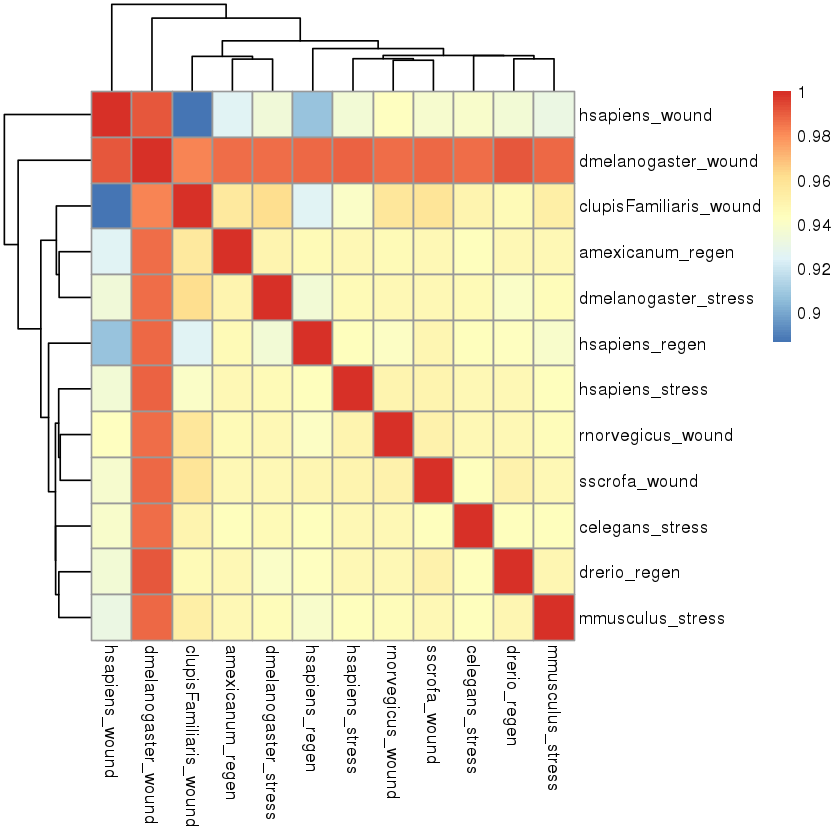

In [49]:
reccurent_random_up_simsem <- mclusterSim(reccurent_random_gene_set, semData=d, measure="Wang", combine="rcmax")
pheatmap(reccurent_random_up_simsem)

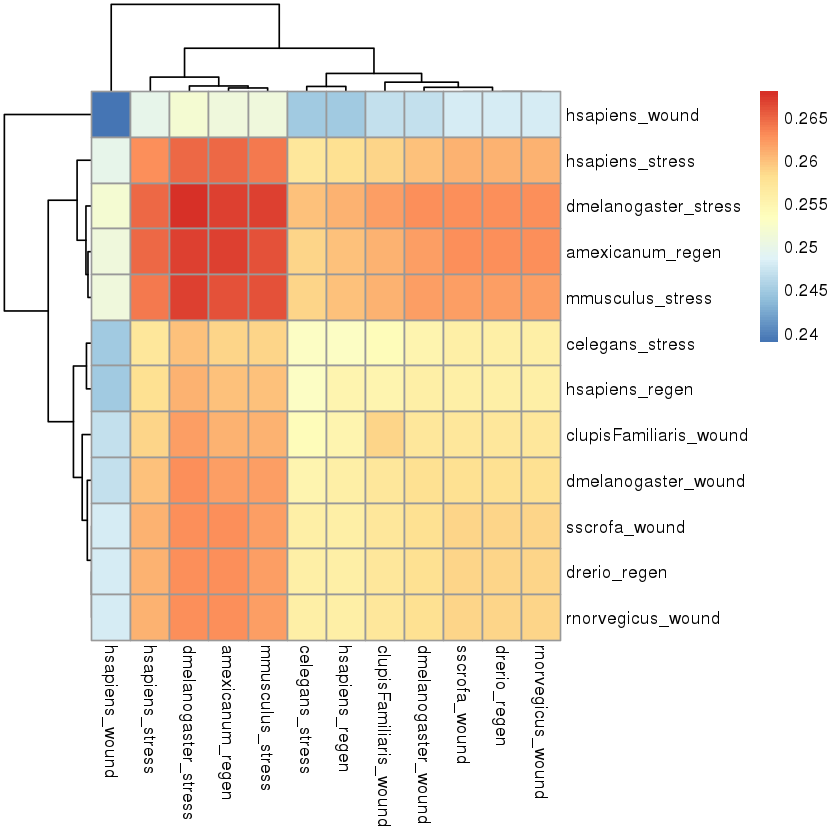

In [66]:
reccurent_random_up_simsem <- mclusterSim(reccurent_random_gene_set, semData=d, measure="Wang", combine="avg")
pheatmap(reccurent_random_up_simsem)

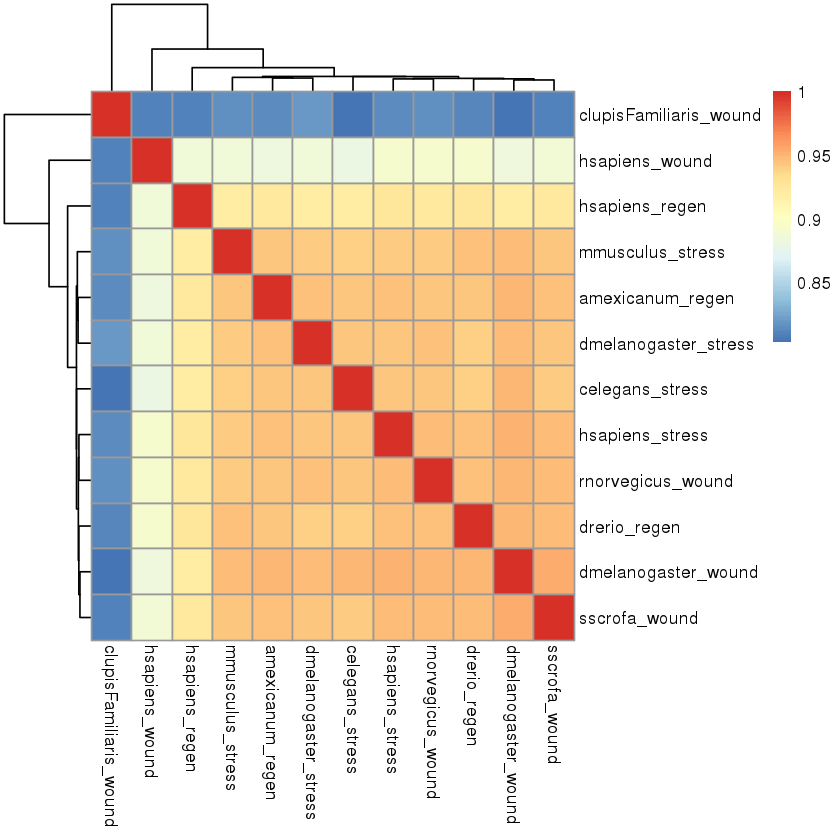

In [67]:
reccurent_random_up_simsem <- mclusterSim(reccurent_random_gene_set, semData=d, measure="Wang", combine="BMA")
pheatmap(reccurent_random_up_simsem)

      a     b     c
a 1.000 0.949 0.948
b 0.949 1.000 0.950
c 0.948 0.950 1.000


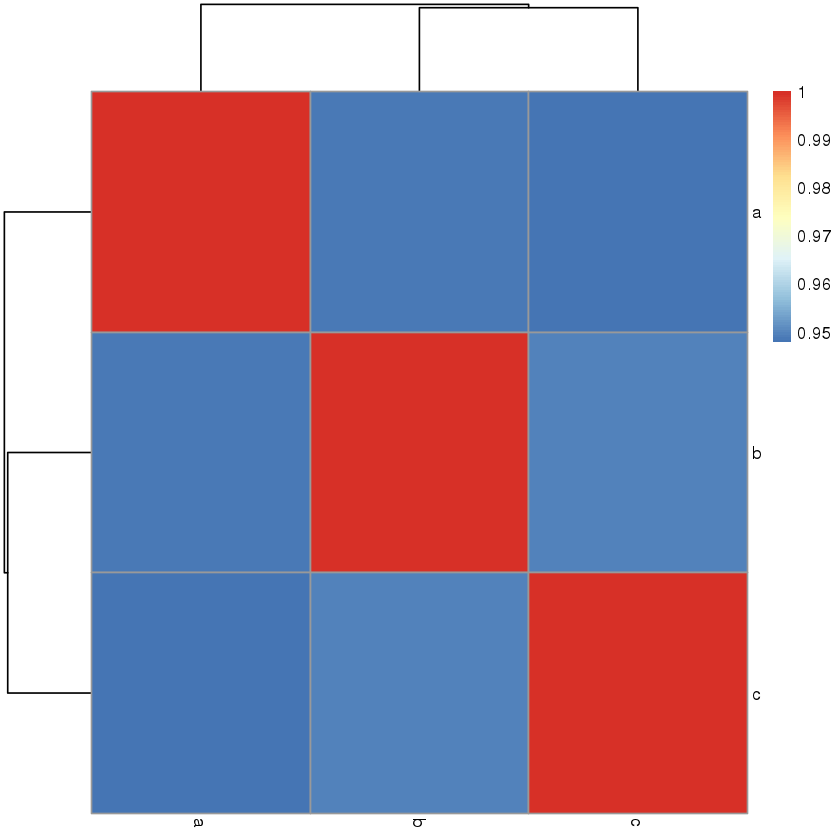

In [62]:
library(org.Hs.eg.db)
x <- org.Hs.egGO
hsEG <- mappedkeys(x)
set.seed <- 123
clusters <- list(a=sample(hsEG, 1000), b=sample(hsEG, 1000), c=sample(hsEG, 1000))
random_sampling <- mclusterSim(clusters, semData=d, measure="Wang", combine="rcmax")
print(random_sampling)
pheatmap(random_sampling)

      a     b     c
a 1.000 0.817 0.817
b 0.817 1.000 0.835
c 0.817 0.835 1.000


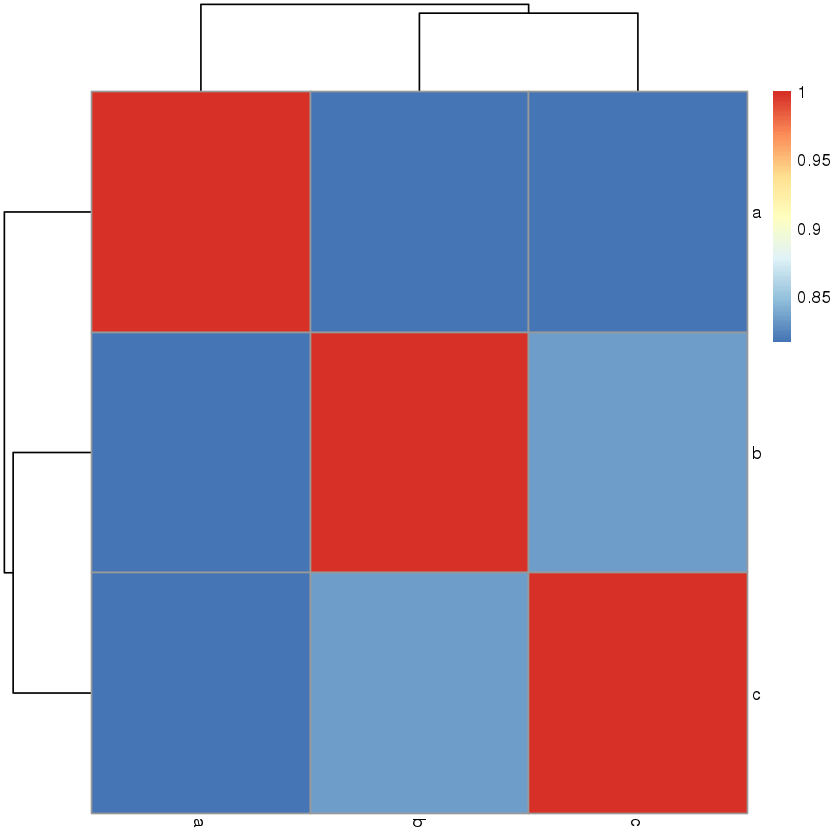

In [76]:
library(org.Hs.eg.db)
x <- org.Hs.egGO
hsEG <- mappedkeys(x)
set.seed <- 123
clusters <- list(a=sample(hsEG, 100), b=sample(hsEG, 100), c=sample(hsEG, 100))
random_sampling <- mclusterSim(clusters, semData=d, measure="Wang", combine="BMA")
print(random_sampling)
pheatmap(random_sampling)

In [75]:
length(intersect(clusters$a, clusters$b))
length(intersect(clusters$b, clusters$c))
length(intersect(clusters$a, clusters$a))

[1] 0

[1] 0

[1] 100

      a     b     c
a 1.000 0.701 0.715
b 0.701 1.000 0.737
c 0.715 0.737 1.000


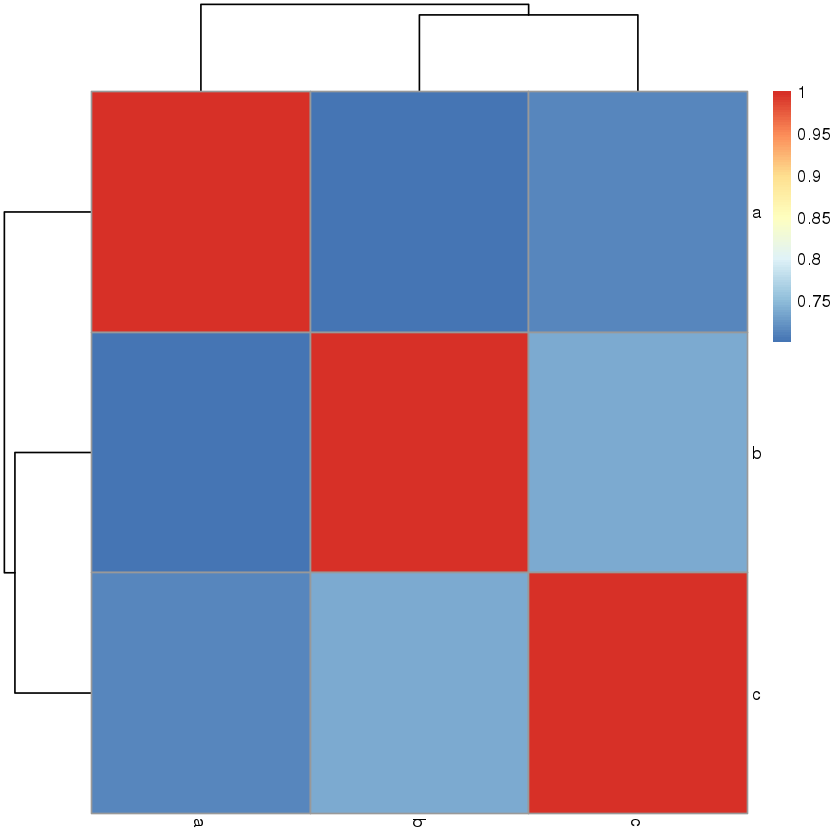

In [64]:
library(org.Hs.eg.db)
x <- org.Hs.egGO
hsEG <- mappedkeys(x)
set.seed <- 123
clusters <- list(a=sample(hsEG, 10), b=sample(hsEG, 10), c=sample(hsEG, 10))
random_sampling <- mclusterSim(clusters, semData=d, measure="Wang", combine="rcmax")
print(random_sampling)
pheatmap(random_sampling)

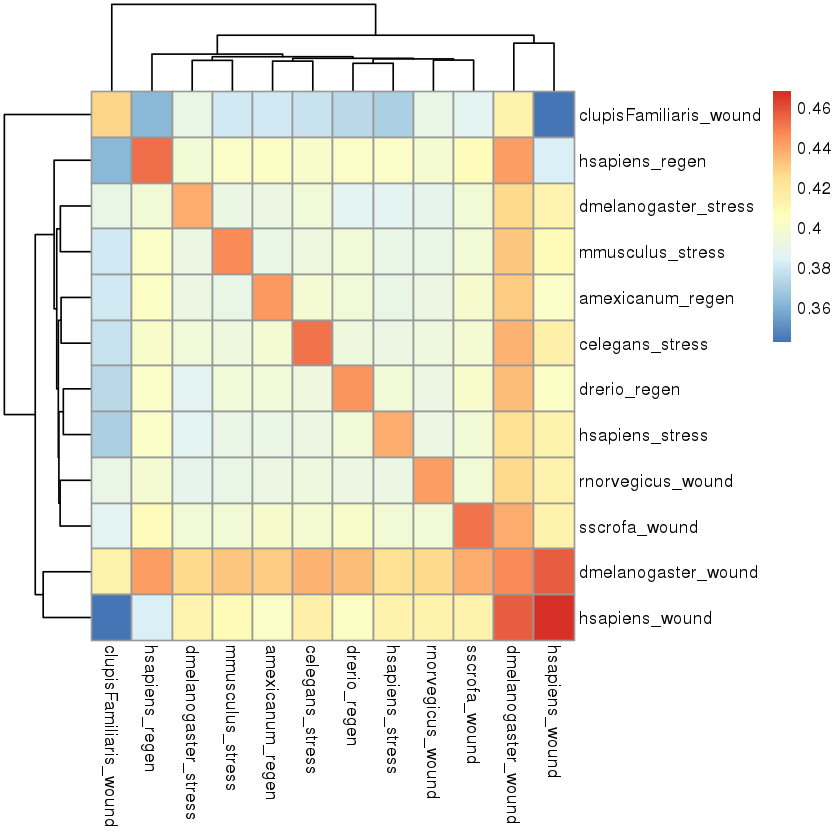

In [65]:
reccurent_random_up_simsem_Resnik <- mclusterSim(reccurent_random_gene_set, semData=d, measure="Resnik", combine="rcmax")
pheatmap(reccurent_random_up_simsem_Resnik)

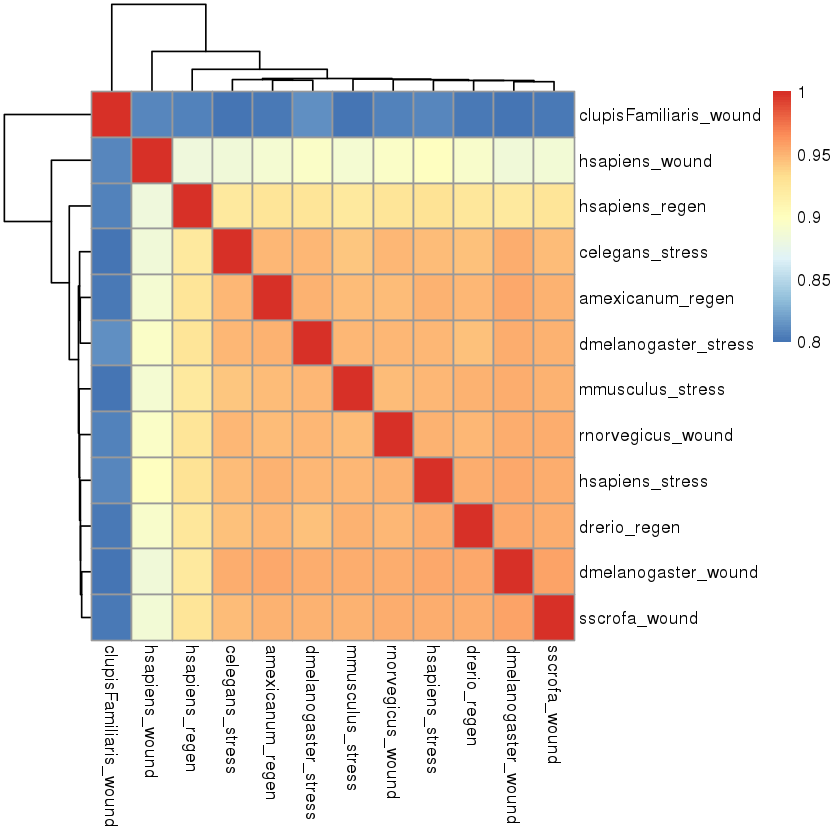

In [40]:
reccurent_random_up_simsem_Lin <- mclusterSim(reccurent_random_gene_set, semData=d, measure="Lin", combine="BMA")
pheatmap(reccurent_random_up_simsem_Lin)

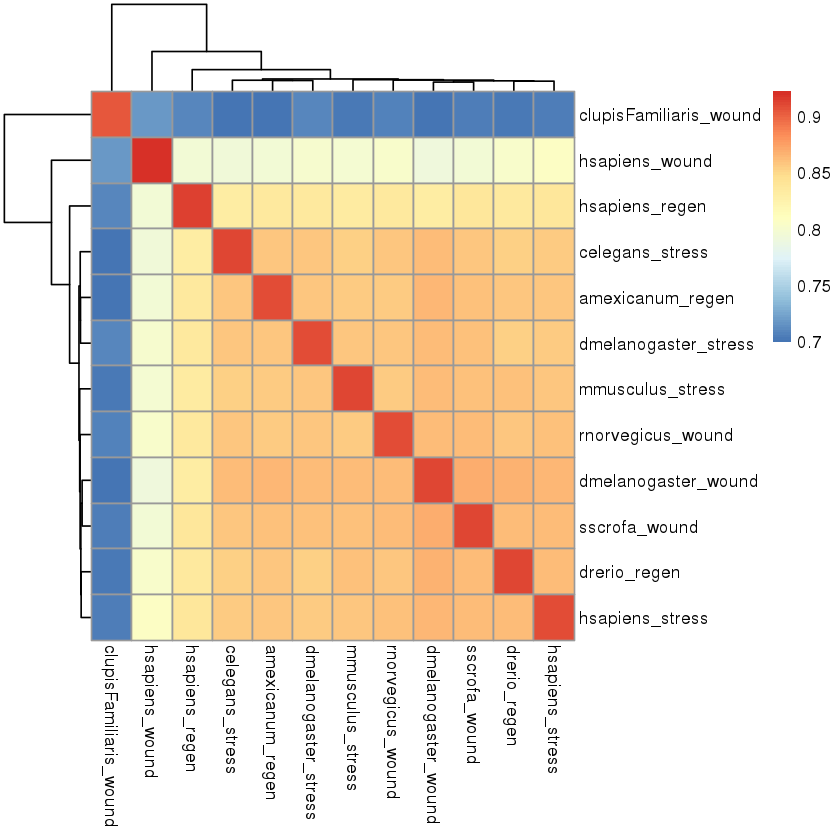

In [41]:
reccurent_random_up_simsem_Rel <- mclusterSim(reccurent_random_gene_set, semData=d, measure="Rel", combine="BMA")
pheatmap(reccurent_random_up_simsem_Rel)

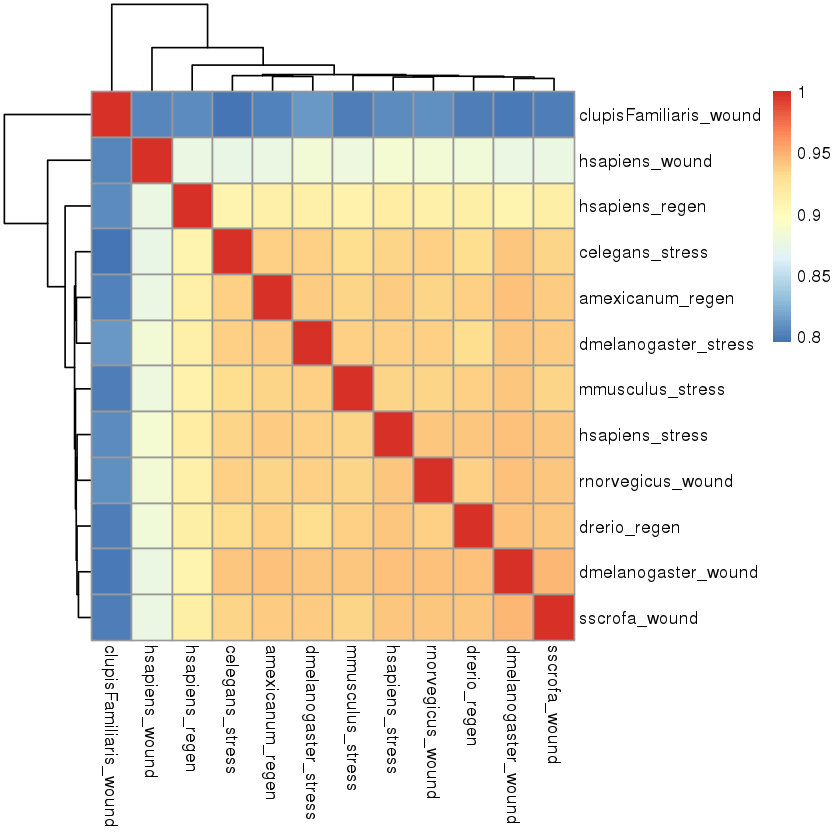

In [42]:
reccurent_random_up_simsem_Jiang <- mclusterSim(reccurent_random_gene_set, semData=d, measure="Jiang", combine="BMA")
pheatmap(reccurent_random_up_simsem_Jiang)

In [51]:
wrs_up_simsem <- readRDS("wrs_up_simsem")

In [52]:
wrs_down_simsem <- readRDS("wrs_down_simsem")

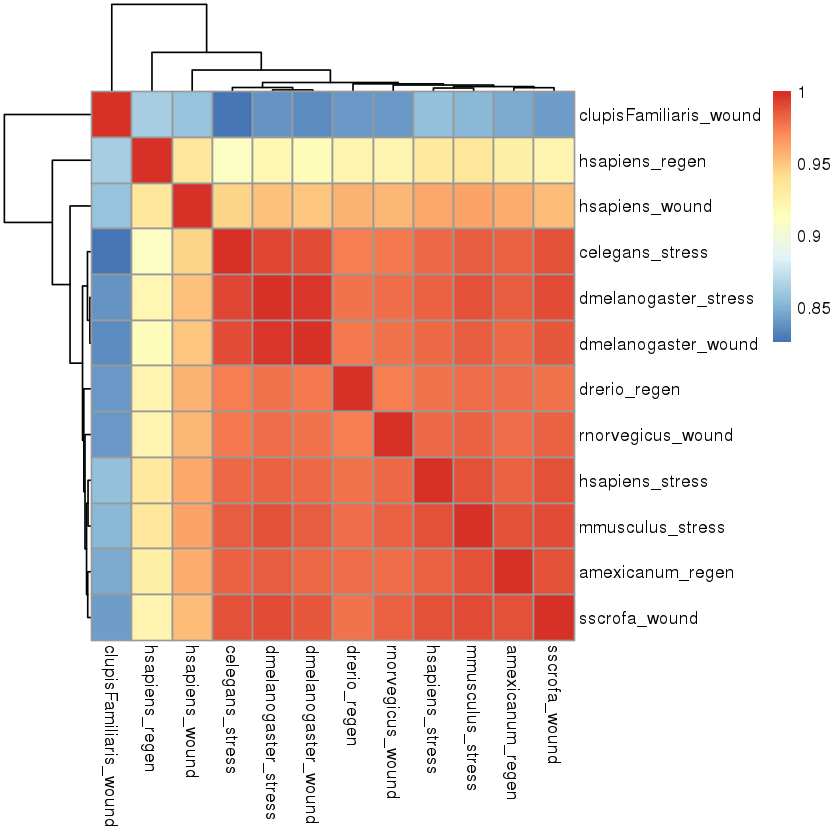

In [53]:
pheatmap(wrs_up_simsem)

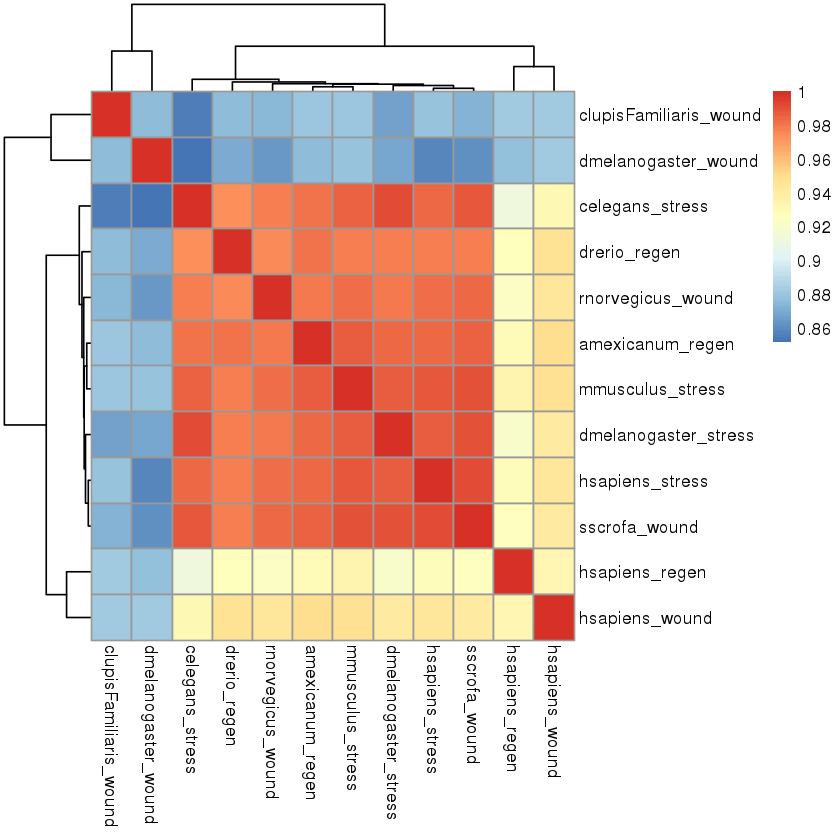

In [104]:
pheatmap(wrs_down_simsem)

In [54]:
recurrent_wrs_up_simsem <- readRDS("recurrent_wrs_up_simsem")

In [55]:
recurrent_wrs_down_simsem <- readRDS("recurrent_wrs_down_simsem")

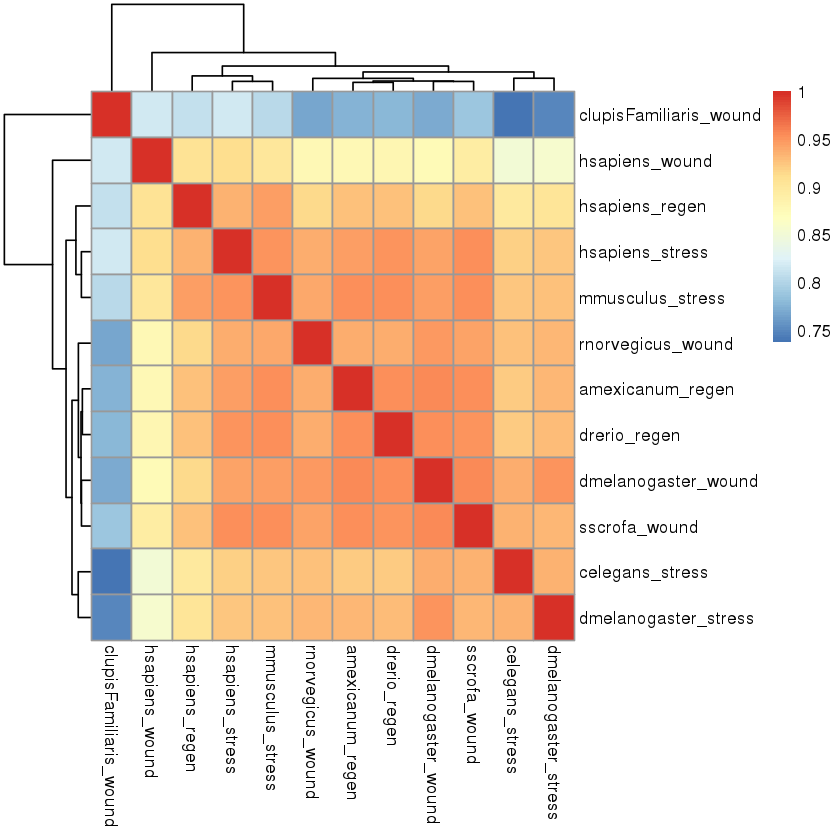

In [56]:
pheatmap(recurrent_wrs_up_simsem)

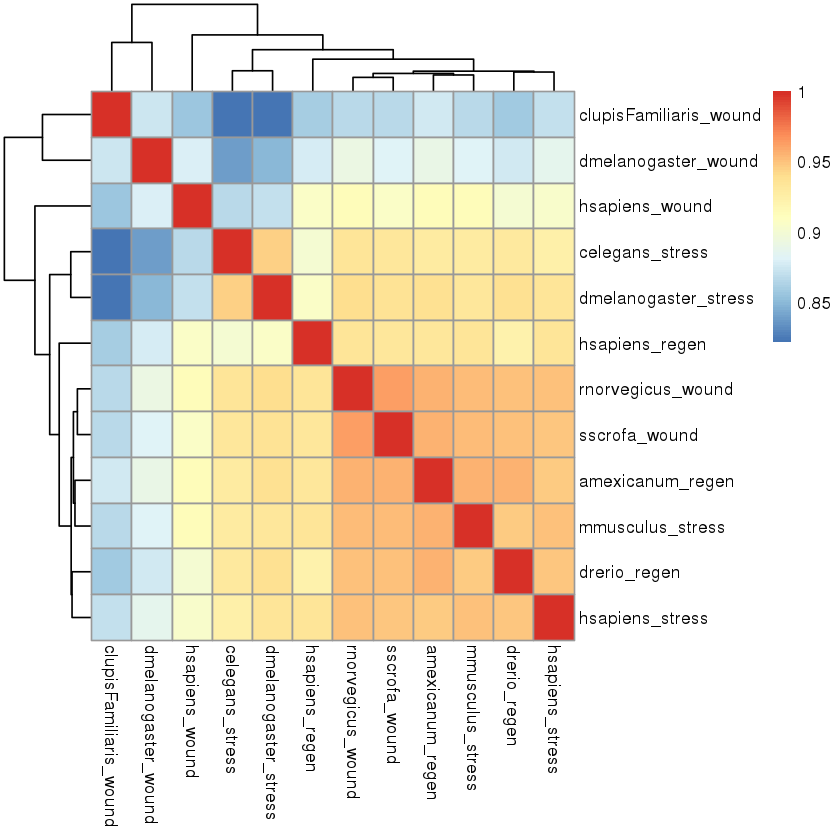

In [57]:
pheatmap(recurrent_wrs_down_simsem)

In [13]:
# non-oncogenic gene sets
library(msigdbr)
library(ggplot2)
library(stats)
library(sets)
library(biomaRt)
library(clusterProfiler)
library(data.table)
library(stringi)
library(pheatmap)
library(tidyr)
library(ggpubr)

# go
go_gene_sets <- msigdbr(species = "Homo sapiens", category = "C5")
unique_go_genes <- unique(go_gene_sets$gene_symbol)

# kegg
kegg_gene_sets <- msigdbr(species = "Homo sapiens", category = "C2", subcategory = "KEGG")
unique_kegg_genes <- unique(kegg_gene_sets$gene_symbol)

# oncogenic

## hallmark
H_gene_sets <- msigdbr(species = "Homo sapiens", category = "H")
unique_H_genes <- unique(H_gene_sets$gene_symbol)

## C2
c2_gene_sets <- msigdbr(species = "Homo sapiens", category = "C2")
unique_c2_genes <- unique(c2_gene_sets$gene_symbol)


## C4 CM
c4_gene_sets <- msigdbr(species = "Homo sapiens", category = "C4", subcategory = "CM")
unique_c4_genes <- unique(c4_gene_sets$gene_symbol)

## cosmic
cosmic_set <- fread("cancer_gene_census.csv")
unique_cosmic_genes <- unique(cosmic_set$`Gene Symbol`)

# Background set of genes
background_set <- fread("background_set.txt")

pathways <- readRDS("pathways.rds")

Registered S3 method overwritten by 'sets':
  method        from   
  print.element ggplot2


Attaching package: ‘sets’


The following object is masked from ‘package:msigdbr’:

    %>%


The following object is masked from ‘package:forcats’:

    %>%


The following object is masked from ‘package:stringr’:

    %>%


The following object is masked from ‘package:dplyr’:

    %>%


The following object is masked from ‘package:purrr’:

    %>%


The following object is masked from ‘package:tidyr’:

    %>%


The following object is masked from ‘package:tibble’:

    %>%


The following object is masked from ‘package:data.table’:

    set


clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


In [14]:
compute_enrichment <- function(foreground_genes,all_genes,background_genes=NULL,pathways=NULL) {
    if (is.null(pathways)) { 
        pathways <- load_pathways()
        pathways <- lapply( pathways, function(pathway_genes) {return(pathway_genes[pathway_genes %in% all_genes])})
    }
    fisher_enrichment_dt <- data.table(pathway=names(pathways),p_value=-1,odds_ratio=-1)
    if (is.null(background_genes)) {
        background_genes <- setdiff(all_genes,foreground_genes)
        #background_genes <- unique(unlist(pathways))
    }

    for (pathway in names(pathways)) {
        pathway_genes <- pathways[[pathway]]
        non_pathway_genes <- setdiff(all_genes,pathway_genes)

        num_in_pathway_and_foreground <- intersect(pathway_genes,foreground_genes) %>% length
        num_in_pathway_and_not_foreground <- intersect(pathway_genes,background_genes) %>% length
        num_not_in_pathway_and_foreground <- intersect(non_pathway_genes,foreground_genes) %>% length
        num_not_in_pathway_and_not_foreground <- intersect(non_pathway_genes,background_genes) %>% length
        fisher_mat <- matrix(c(num_in_pathway_and_foreground,num_in_pathway_and_not_foreground,
                              num_not_in_pathway_and_foreground,num_not_in_pathway_and_not_foreground),
                             nrow=2,ncol=2,byrow=T)
        
        test_res <- fisher.test(fisher_mat,alternative="g")
        pathway_ <- pathway
        fisher_enrichment_dt[pathway==pathway_,`:=`(p_value=test_res$p.value, odds_ratio=test_res$estimate,
        num_p_fg=num_in_pathway_and_foreground,num_p_bg=num_in_pathway_and_not_foreground,
        num_not_p_fg=num_not_in_pathway_and_foreground,num_not_p_bg=num_not_in_pathway_and_not_foreground)]
    }
    fisher_enrichment_dt[,q_value:=p.adjust(p_value)]

    return(fisher_enrichment_dt)
}


In [15]:
get_enrichment_data <- function(current_files, current_pathways){
    total_enrichment_pathways <- names(current_pathways)
    pathwaysDF <- data.frame("pathways" = total_enrichment_pathways)
    pathwaysDF_odds <- data.frame("pathways" = total_enrichment_pathways)
    for(i in 1:length(current_files)) {
        spec_exptype <- names(current_files)[i]
        
        current_hgnc <- getLDS(attributes=c("entrezgene_id"), filters="entrezgene_id",
                             values=current_files[[spec_exptype]],
                             mart=human,attributesL=c("hgnc_symbol"),
                             martL=human)
        total_genes <- current_hgnc$HGNC.symbol
        
        
        enrichment_test <- compute_enrichment(foreground_genes = total_genes,
                                               all_genes = background_set$gene,
                                               pathways = current_pathways)
        subset_enrichment_test  <- enrichment_test[,c("q_value")]
        subset_enrichment_test_odds  <- enrichment_test[,c("odds_ratio")]
        rownames(subset_enrichment_test) <-  enrichment_test$pathway
        rownames(subset_enrichment_test_odds) <-  enrichment_test$pathway

        pathwaysDF <- cbind(pathwaysDF, subset_enrichment_test)
        pathwaysDF_odds <- cbind(pathwaysDF_odds, subset_enrichment_test_odds)
        #saveRDS(subset_enrichment_test, file = new_file_name)
    }
    
    all_qvals <- pathwaysDF[,2:length(pathwaysDF)]
    rownames(all_qvals) <- total_enrichment_pathways
    colnames(all_qvals) <- names(current_files)
    
    all_odds <- pathwaysDF_odds[,2:length(pathwaysDF_odds)]
    rownames(all_odds) <- total_enrichment_pathways
    colnames(all_odds) <- names(current_files)
    
    enrichment_heatmap <- pheatmap(as.matrix(log(all_qvals)), fontsize = 8)
    return(list("matrix" = all_qvals, "odds_matrix" = all_odds, "heatmap" = enrichment_heatmap))
}

In [55]:
makeColorRampPalette <- function(colors, cutoff.fraction, num.colors.in.palette)
{
  stopifnot(length(colors) == 4)
  ramp1 <- colorRampPalette(colors[1:2])(num.colors.in.palette * cutoff.fraction)
  ramp2 <- colorRampPalette(colors[3:4])(num.colors.in.palette * (1 - cutoff.fraction))
  return(c(ramp1, ramp2))
}

In [56]:
change_matrix <- function(fdr_mat, odds_mat) {
    new_mat <- matrix(nrow = nrow(fdr_mat), ncol = ncol(fdr_mat))
    
    for(i in 1:nrow(fdr_mat)) {
        for(j in 1:ncol(fdr_mat)) {
            
            if(fdr_mat[i,j] < .05) {
                new_mat[i,j] <- odds_mat[i,j]
            }else {
                new_mat[i,j] <- 0.001
            }
        }
    }
    
    rownames(new_mat) <- rownames(fdr_mat)
    colnames(new_mat) <- colnames(fdr_mat)
    
    cutoff.distance <- 0.002  
    cols <- makeColorRampPalette(c("white", "white",    # distances 0 to 0.002 colored from white to red
                                   "red", "blue"), # distances 0.002 to max(distmat) colored from green to black
                                 cutoff.distance / max(new_mat),
                                 100)

    new_heatmap <- pheatmap(new_mat,
                            color = cols,
                            fontsize = 8)
    
    return(list("matrix"=new_mat, "heatmap" = new_heatmap))
    
}

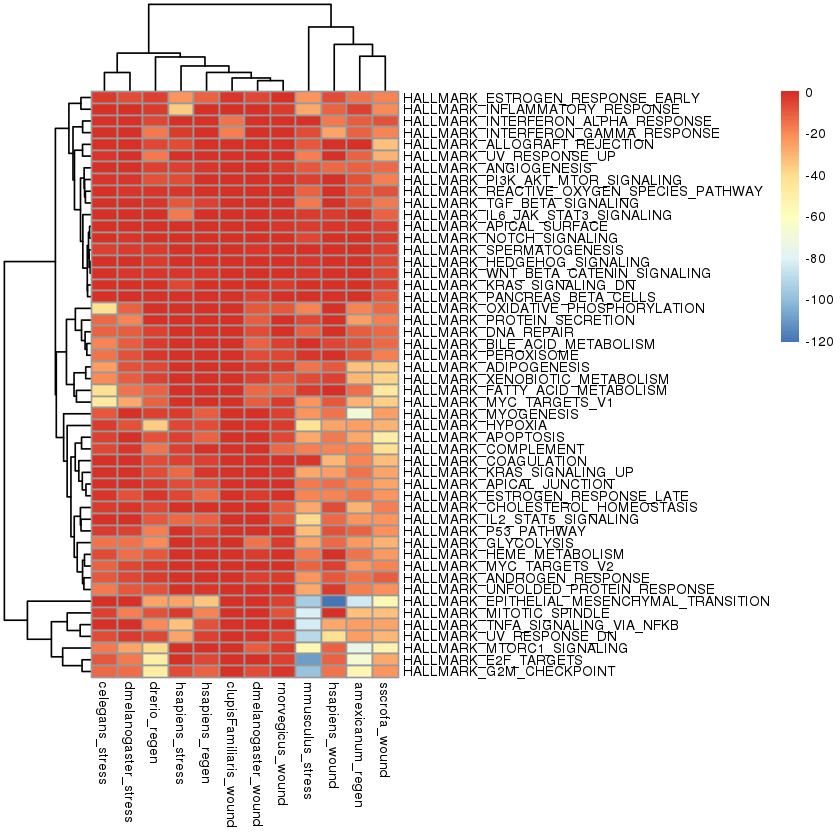

In [57]:
spec_exp_hallmark_up <- get_enrichment_data(wrs_list[["upregulated"]], pathways[["HALLMARK"]])

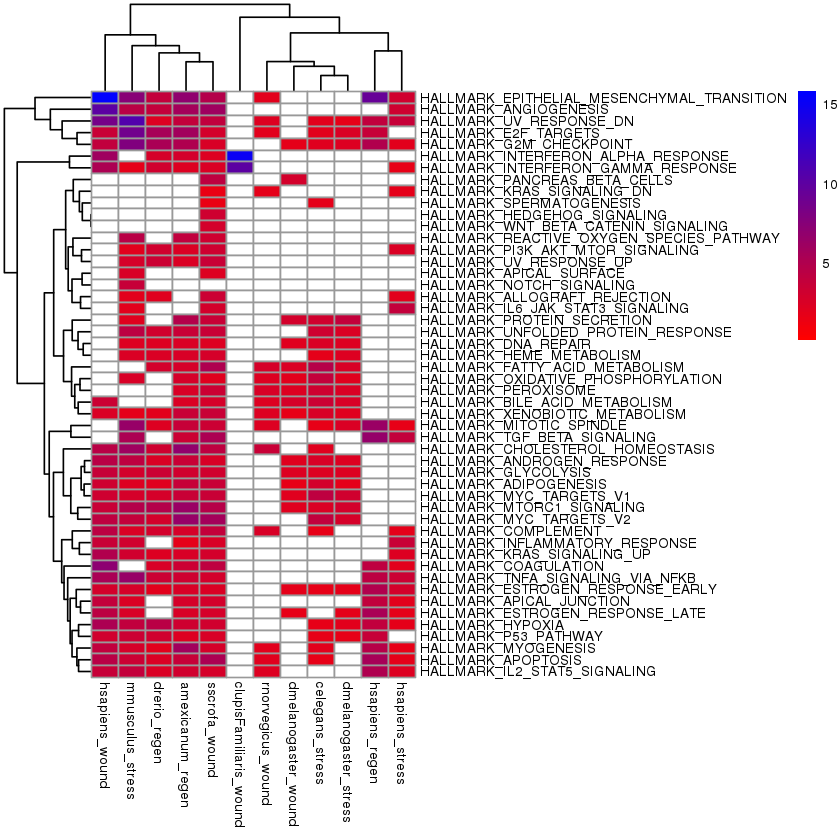

In [58]:
spec_exp_hallmark_up_new <- change_matrix(spec_exp_hallmark_up$matrix, spec_exp_hallmark_up$odds_matrix)

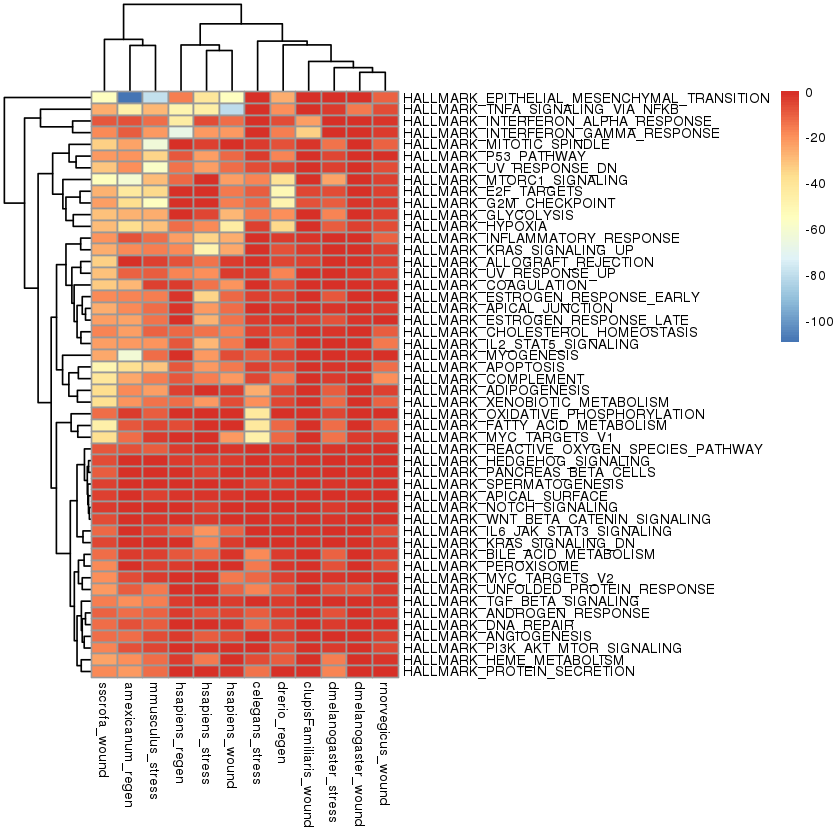

In [59]:
spec_exp_hallmark_down <- get_enrichment_data(wrs_list[["downregulated"]], pathways[["HALLMARK"]])

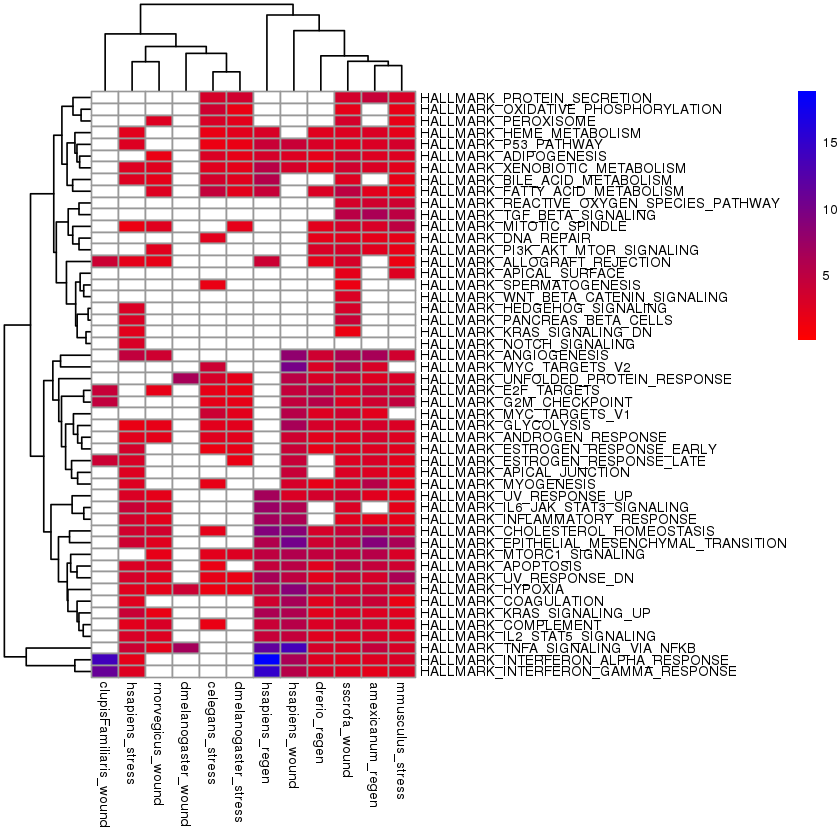

In [60]:
spec_exp_hallmark_down_new <- change_matrix(spec_exp_hallmark_down$matrix, spec_exp_hallmark_down$odds_matrix)

In [61]:
non_zero_reccurent_up<- recurrent_wrs_list[["upregulated"]][as.numeric(summary(recurrent_wrs_list[["upregulated"]])[,1]) != 0]
non_zero_reccurent_down<- recurrent_wrs_list[["downregulated"]][as.numeric(summary(recurrent_wrs_list[["downregulated"]])[,1]) != 0]

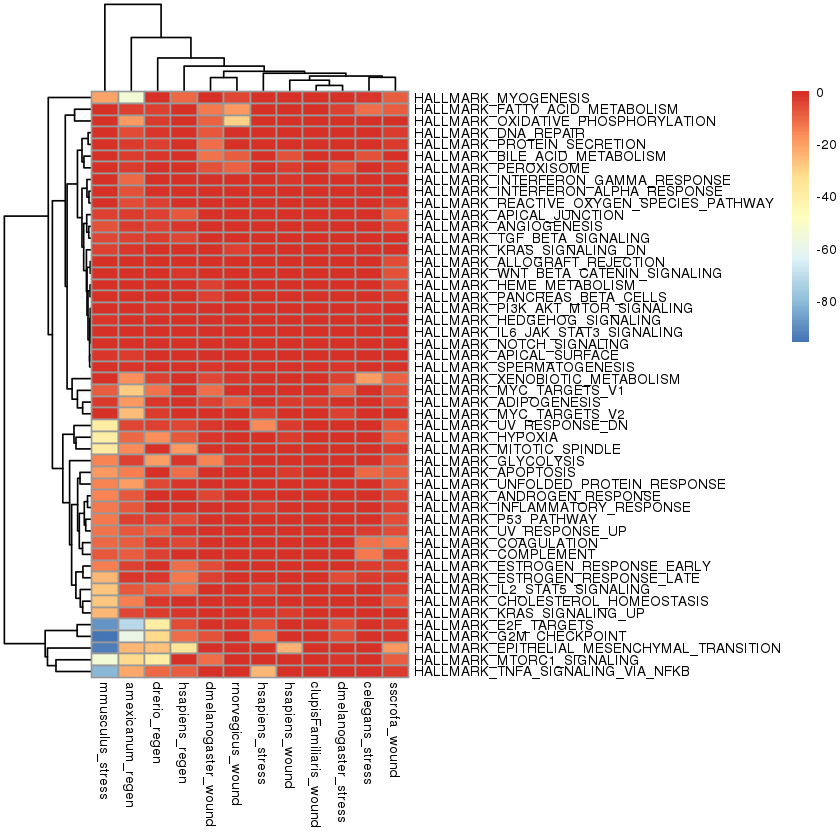

In [62]:
spec_exp_hallmark_up_reccurent <- get_enrichment_data(non_zero_reccurent_up, pathways[["HALLMARK"]])

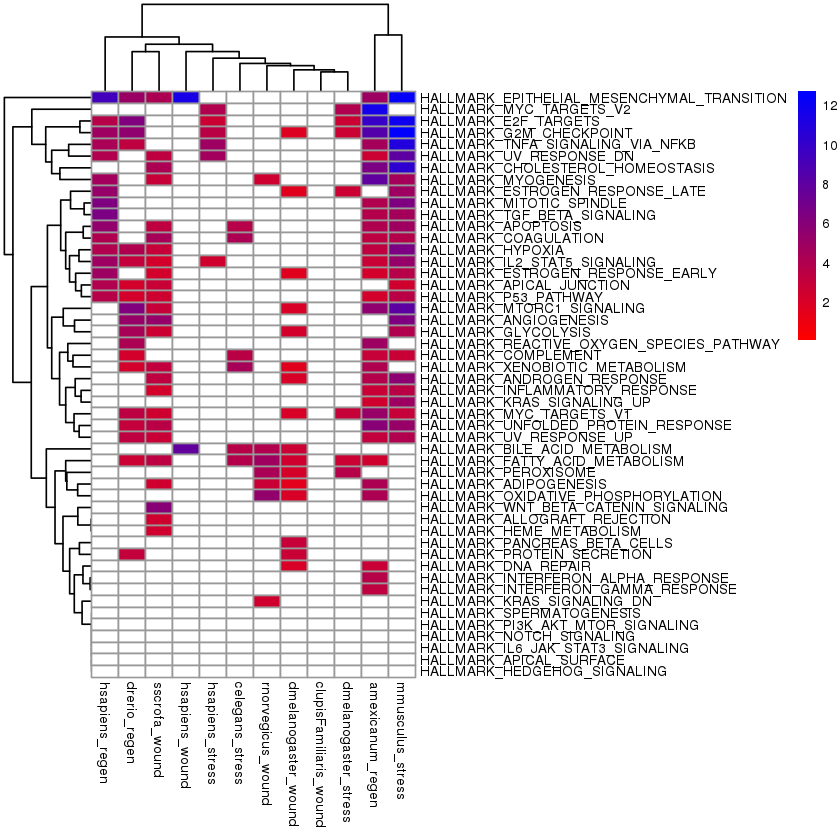

In [63]:
spec_exp_hallmark_up_reccurent_new <- change_matrix(spec_exp_hallmark_up_reccurent$matrix, spec_exp_hallmark_up_reccurent$odds_matrix)

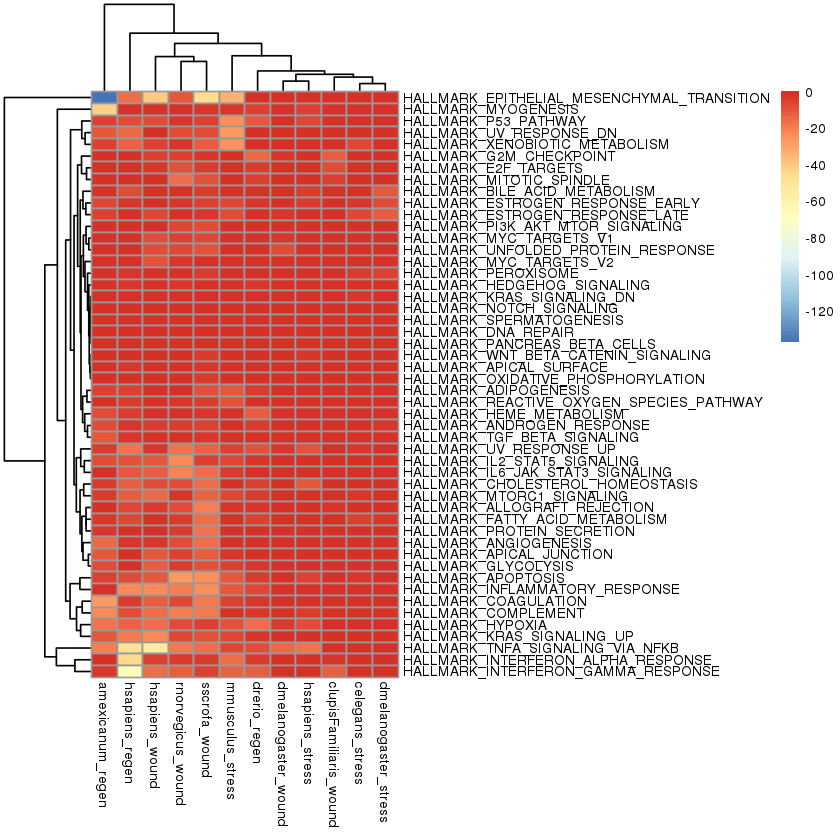

In [64]:
spec_exp_hallmark_down_reccurent <- get_enrichment_data(non_zero_reccurent_down,pathways[["HALLMARK"]])

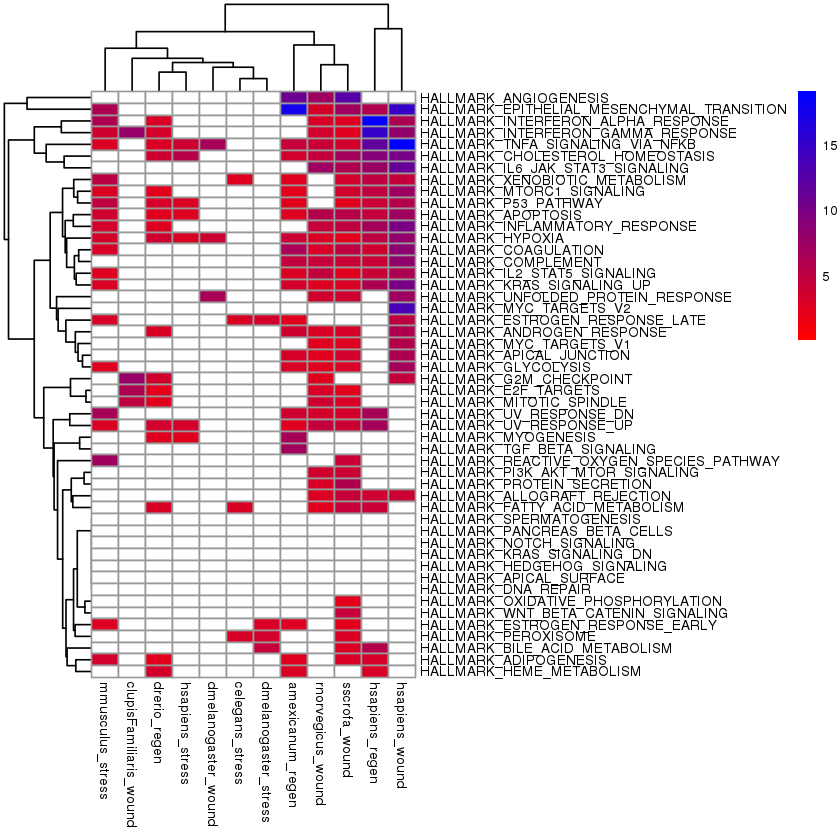

In [65]:
spec_exp_hallmark_down_reccurent_new <- change_matrix(spec_exp_hallmark_down_reccurent$matrix, spec_exp_hallmark_down_reccurent$odds_matrix)

In [60]:
cell_type_names <- sub("\\.[a-z]*$","",list.files("proteinAtlas/"))
cell_type_files <- list.files("proteinAtlas/")
cell_types <- list()

for(i in 1:length(cell_type_files)) {
    cell_types[[cell_type_names[i]]] <- fread(paste("proteinAtlas/",cell_type_files[i],sep=""), header=FALSE)$V1
}


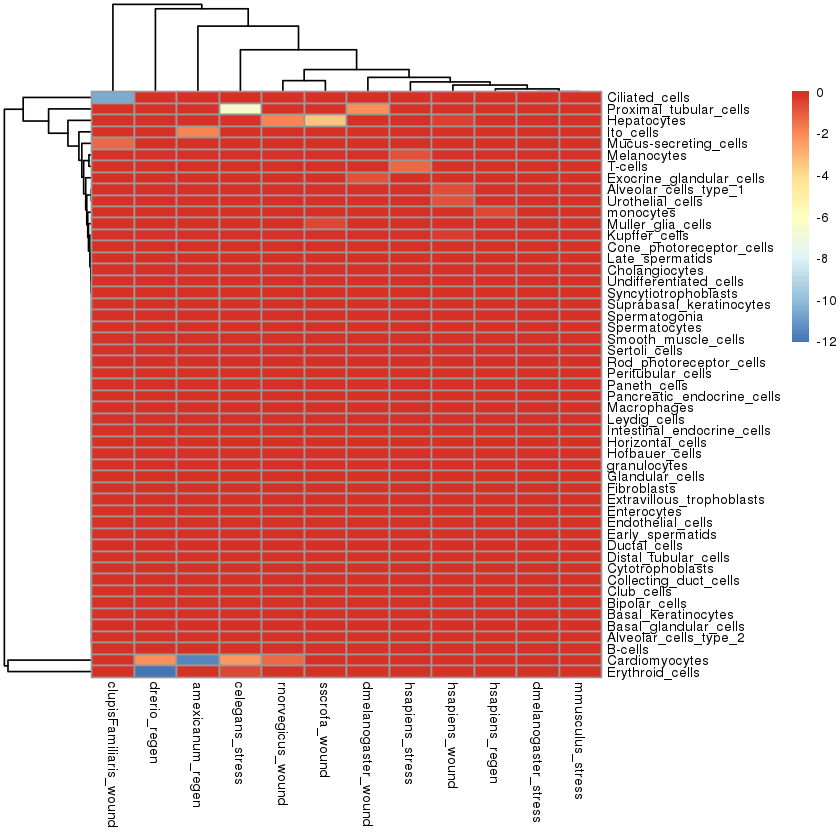

In [67]:
spec_exp_cell_type_up <- get_enrichment_data(wrs_list[["upregulated"]], cell_types)

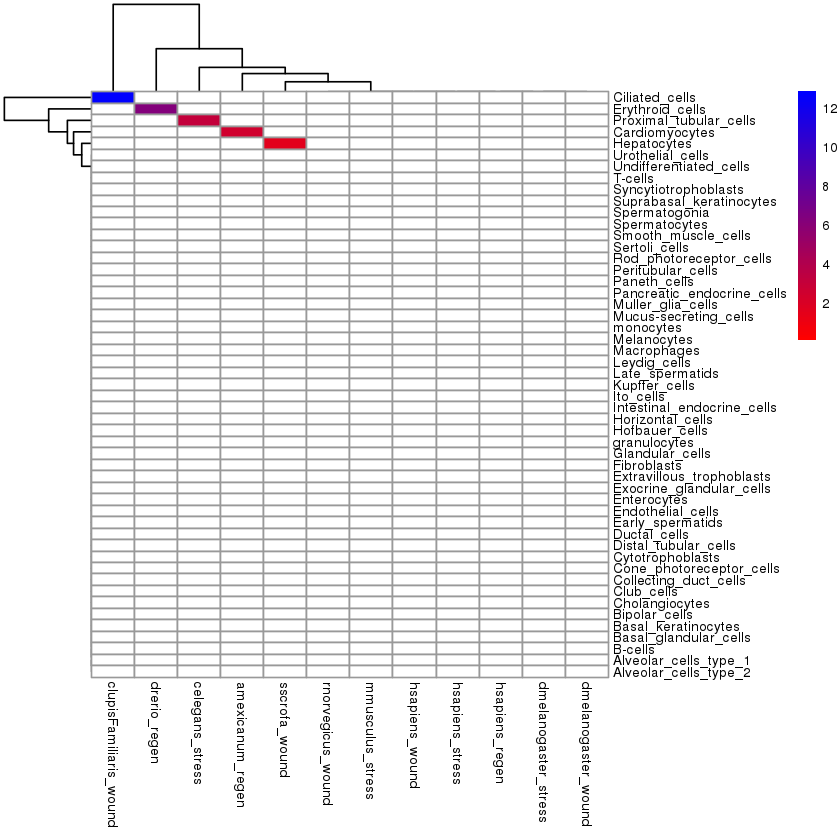

In [68]:
spec_exp_cell_type_up_new <- change_matrix(spec_exp_cell_type_up$matrix, spec_exp_cell_type_up$odds_matrix)

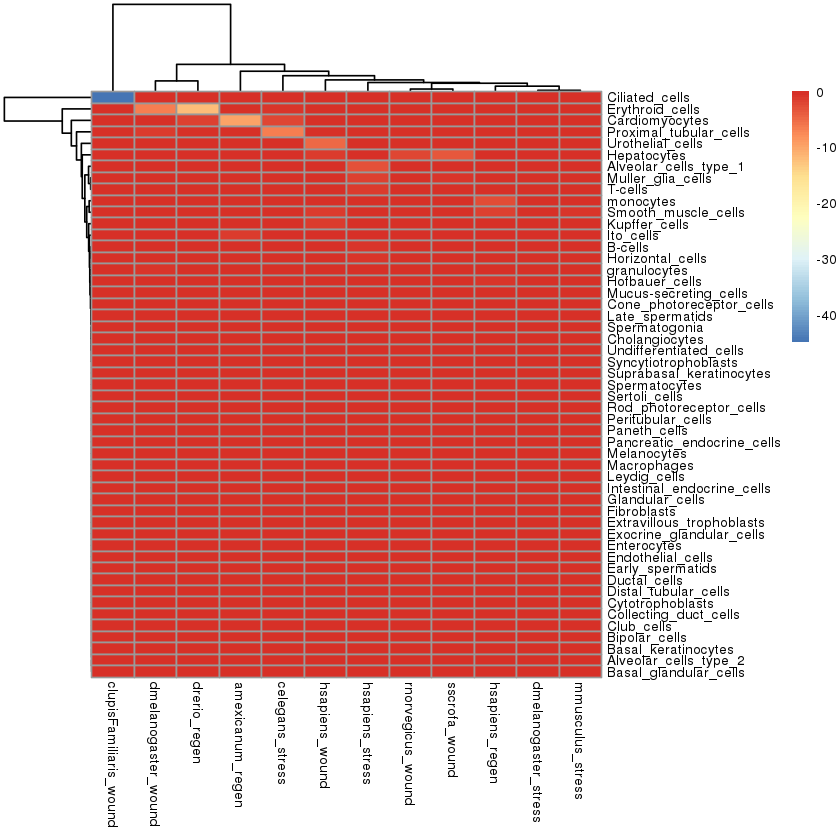

In [69]:
spec_exp_cell_type_down <- get_enrichment_data(wrs_list[["downregulated"]], cell_types)

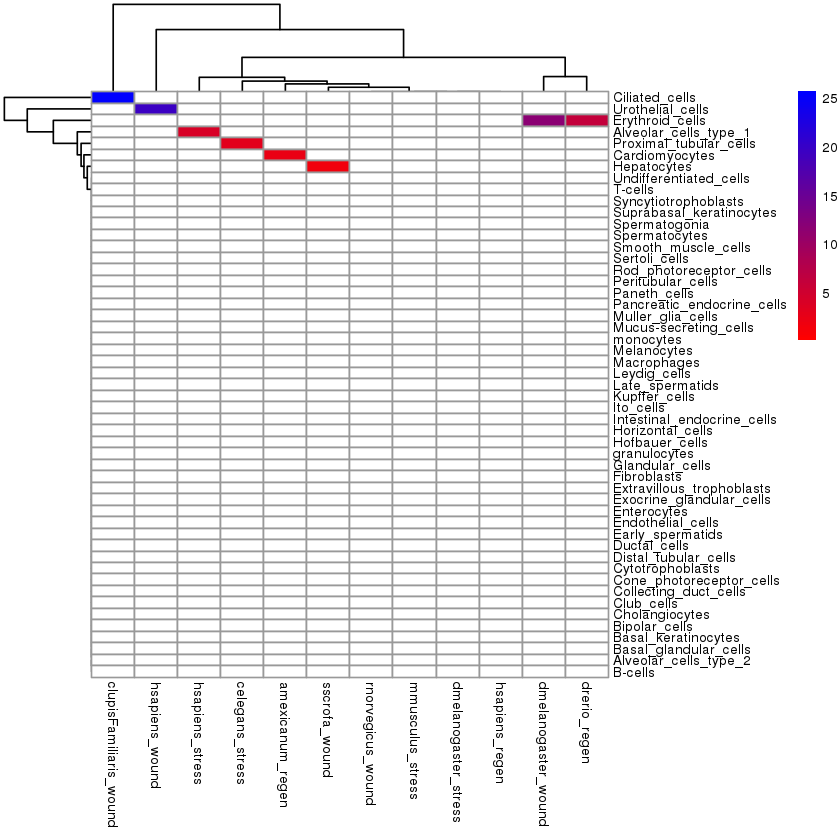

In [70]:
spec_exp_cell_type_down_new <- change_matrix(spec_exp_cell_type_down$matrix, spec_exp_cell_type_down$odds_matrix)

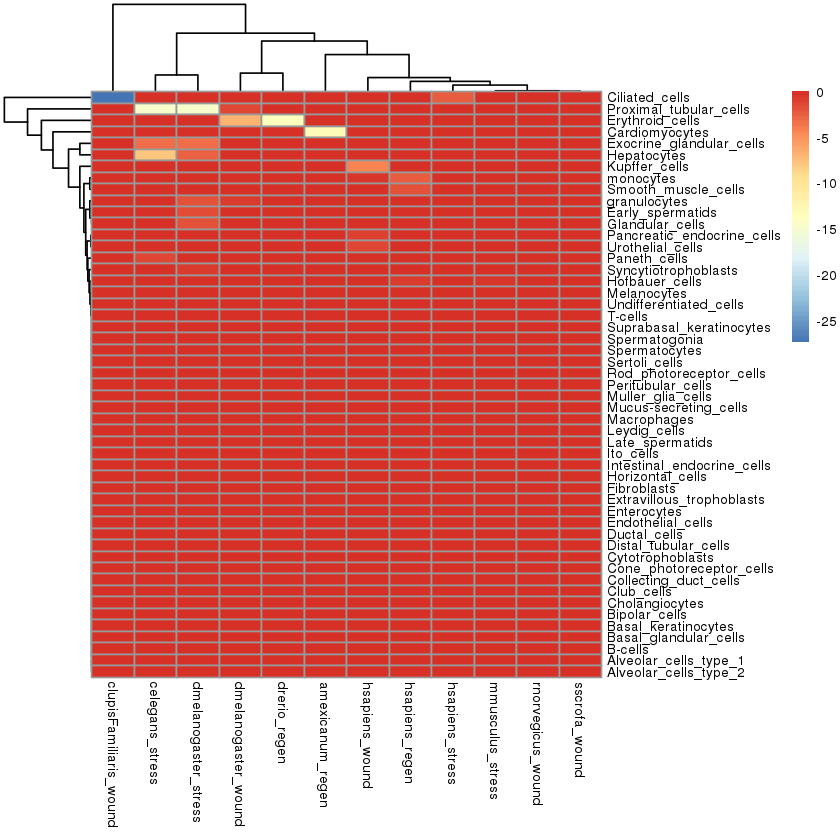

In [71]:
spec_exp_cell_type_up_reccurent <- get_enrichment_data(non_zero_reccurent_down,cell_types)

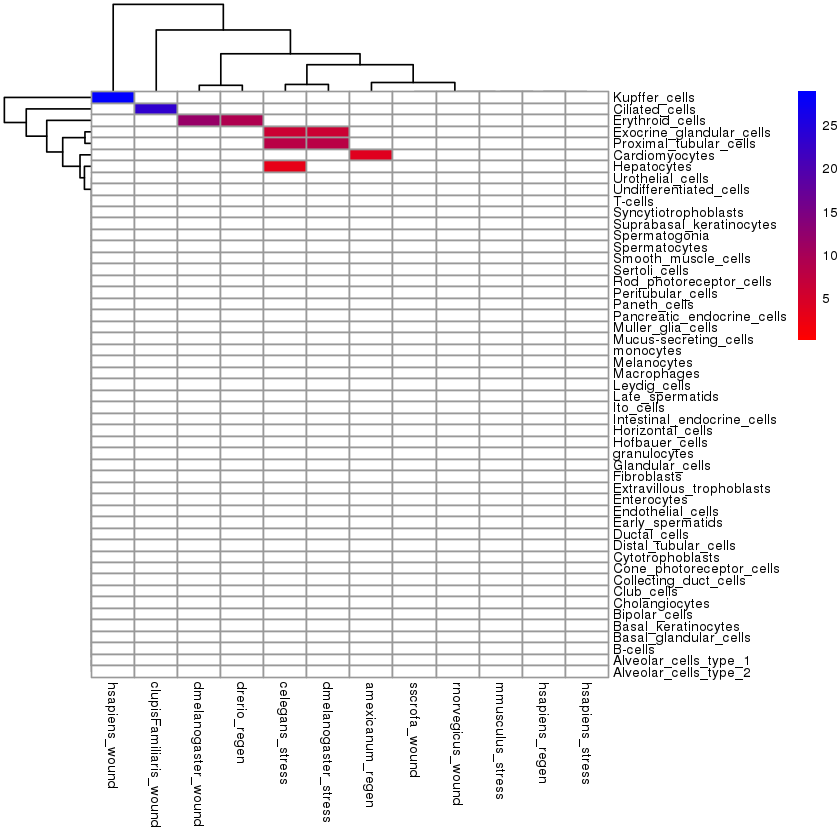

In [72]:
spec_exp_cell_type_up_reccurent_new <- change_matrix(spec_exp_cell_type_up_reccurent$matrix, spec_exp_cell_type_up_reccurent$odds_matrix)

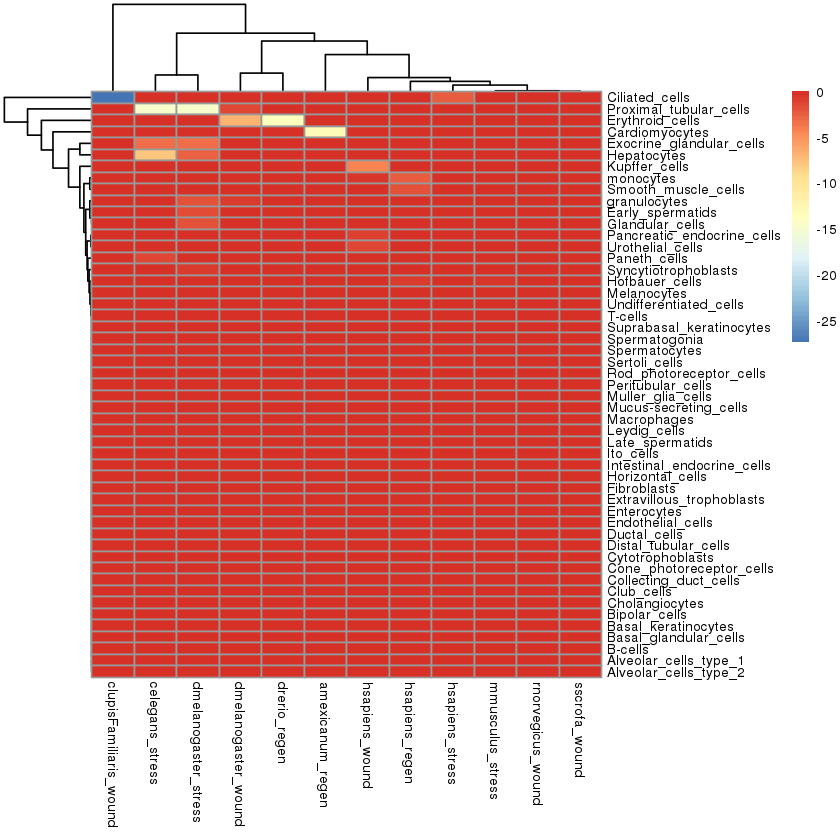

In [73]:
spec_exp_cell_type_down_reccurent <- get_enrichment_data(non_zero_reccurent_down,cell_types)

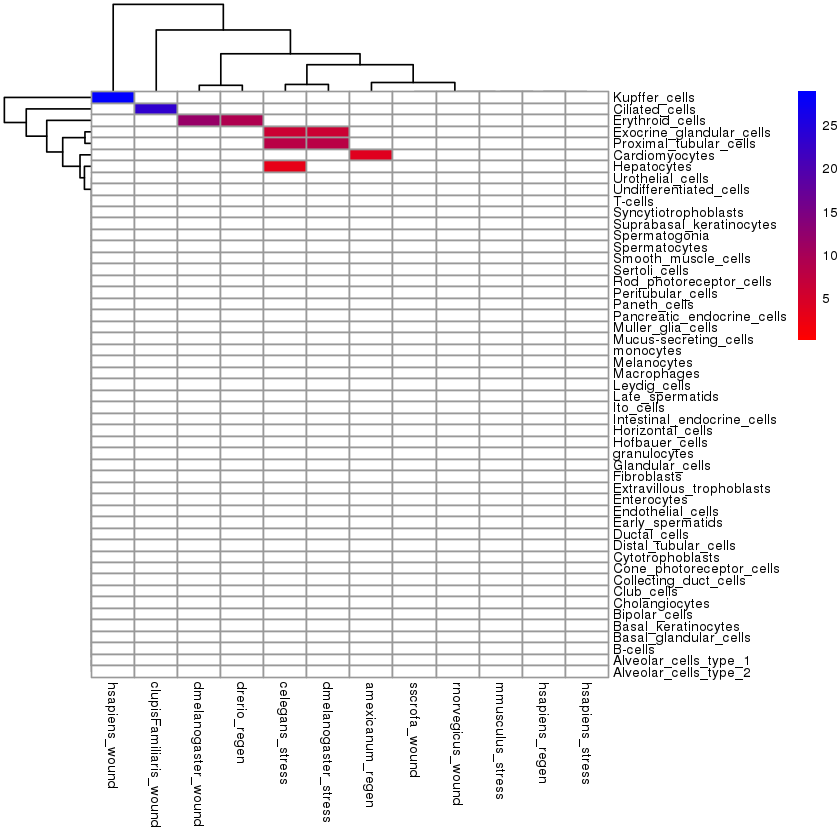

In [74]:
spec_exp_cell_type_down_reccurent_new <- change_matrix(spec_exp_cell_type_down_reccurent$matrix, spec_exp_cell_type_down_reccurent$odds_matrix)

In [75]:
tissue_type_names <- sub("_top_1000.txt","",list.files("/data/timonaj/tissue_most_expressed/"))
tissue_type_files <- list.files("/data/timonaj/tissue_most_expressed/")
tissue_types <- list()

for(i in 1:length(tissue_type_files)) {
    ensembl_genes <- fread(paste("/data/timonaj/tissue_most_expressed/",tissue_type_files[i],sep=""), header=FALSE)$V1
    
    mapping <- getLDS(attributes=c("ensembl_gene_id"), filters="ensembl_gene_id",
                        values=gsub("\\..*","", ensembl_genes),
                        mart=human,attributesL=c("ensembl_gene_id","hgnc_symbol"),
                        martL=human)
    
    tissue_types[[tissue_type_names[i]]] <- mapping[,"HGNC.symbol"]
}


In [76]:
summary(tissue_types)

                Length Class  Mode     
Adipose_Tissue  962    -none- character
Adrenal_Gland   962    -none- character
Bladder         939    -none- character
Blood           952    -none- character
Blood_Vessel    963    -none- character
Brain           955    -none- character
Breast          957    -none- character
Cervix_Uteri    914    -none- character
Colon           944    -none- character
Esophagus       969    -none- character
Fallopian_Tube  922    -none- character
Heart           961    -none- character
Kidney          957    -none- character
Liver           961    -none- character
Lung            957    -none- character
Muscle          969    -none- character
Nerve           949    -none- character
Ovary           937    -none- character
Pancreas        953    -none- character
Pituitary       941    -none- character
Prostate        934    -none- character
Salivary_Gland  950    -none- character
Skin            965    -none- character
Small_Intestine 938    -none- character


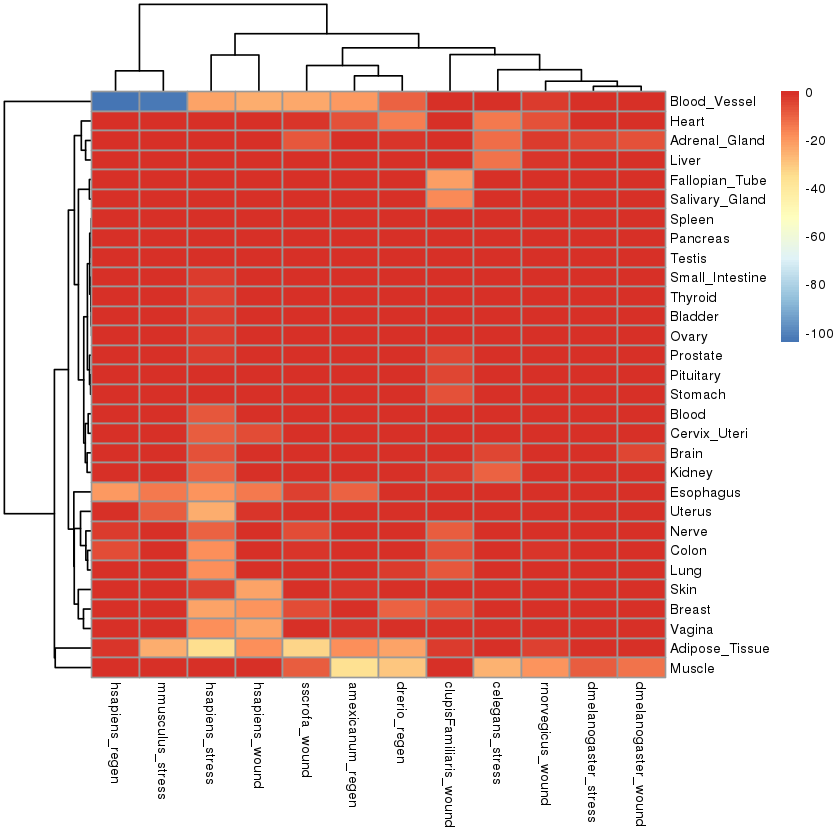

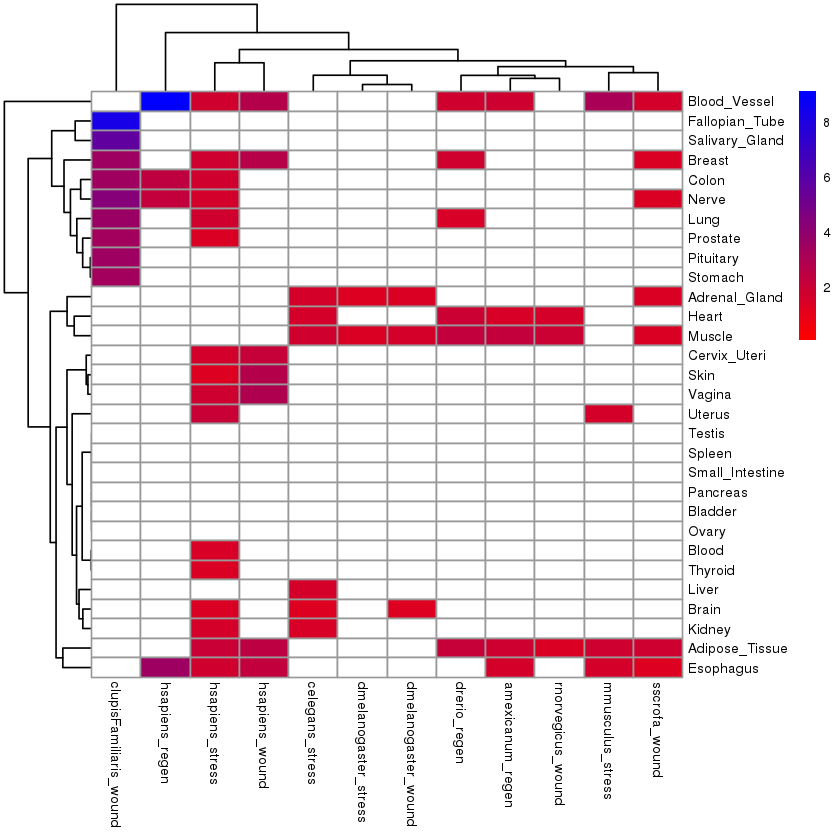

In [77]:
spec_exp_tissue_type_up <- get_enrichment_data(wrs_list[["upregulated"]], tissue_types)
spec_exp_tissue_type_up_new <- change_matrix(spec_exp_tissue_type_up$matrix, spec_exp_tissue_type_up$odds_matrix)

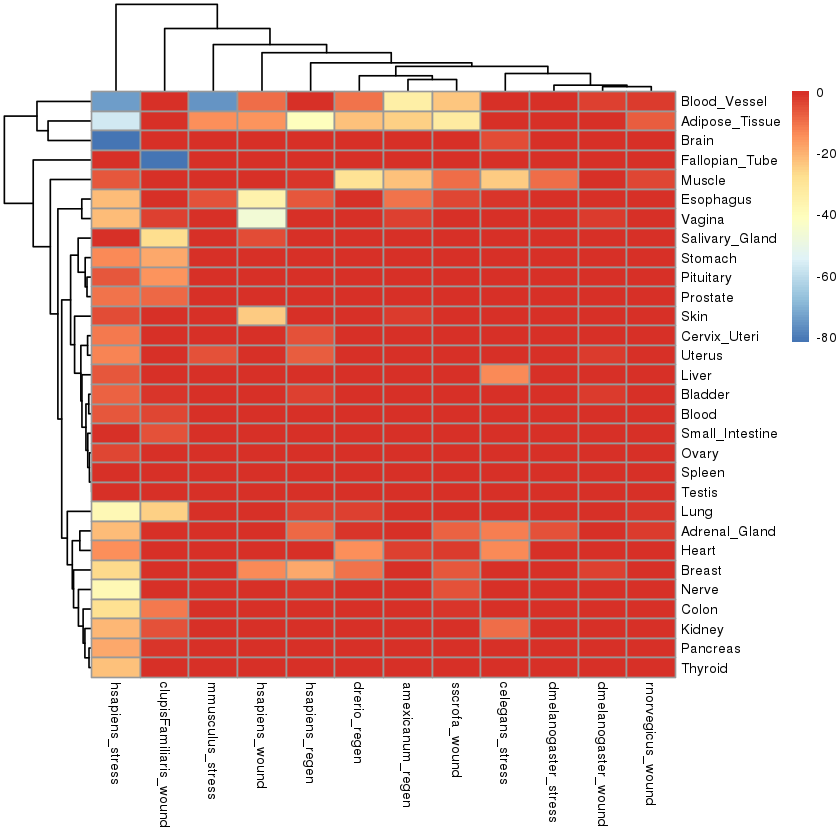

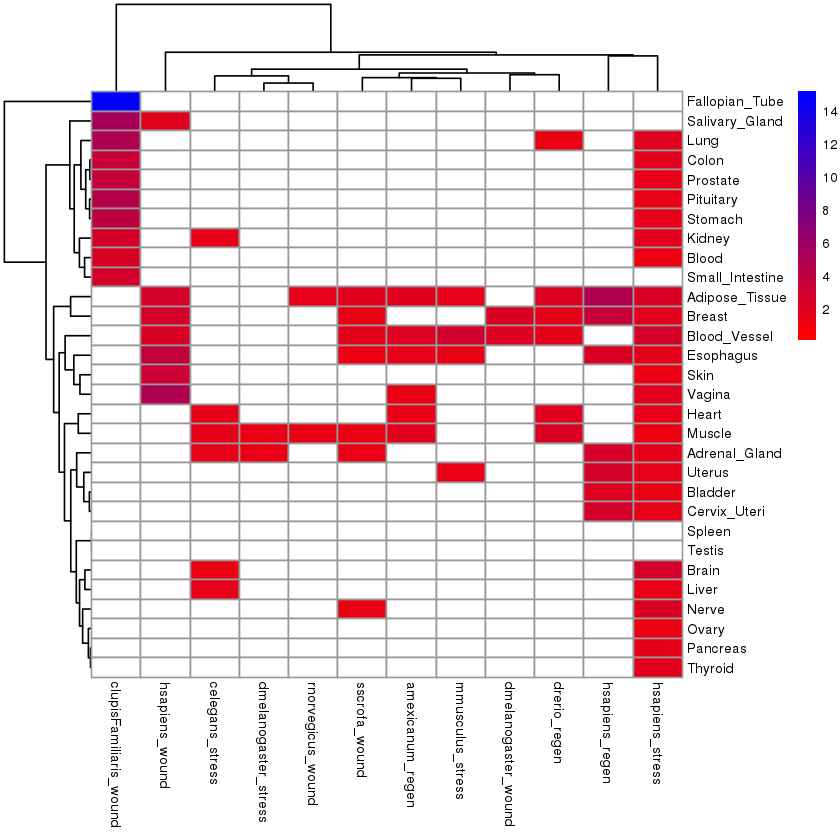

In [78]:
spec_exp_tissue_type_down <- get_enrichment_data(wrs_list[["downregulated"]], tissue_types)
spec_exp_tissue_type_down_new <- change_matrix(spec_exp_tissue_type_down$matrix, spec_exp_tissue_type_down$odds_matrix)

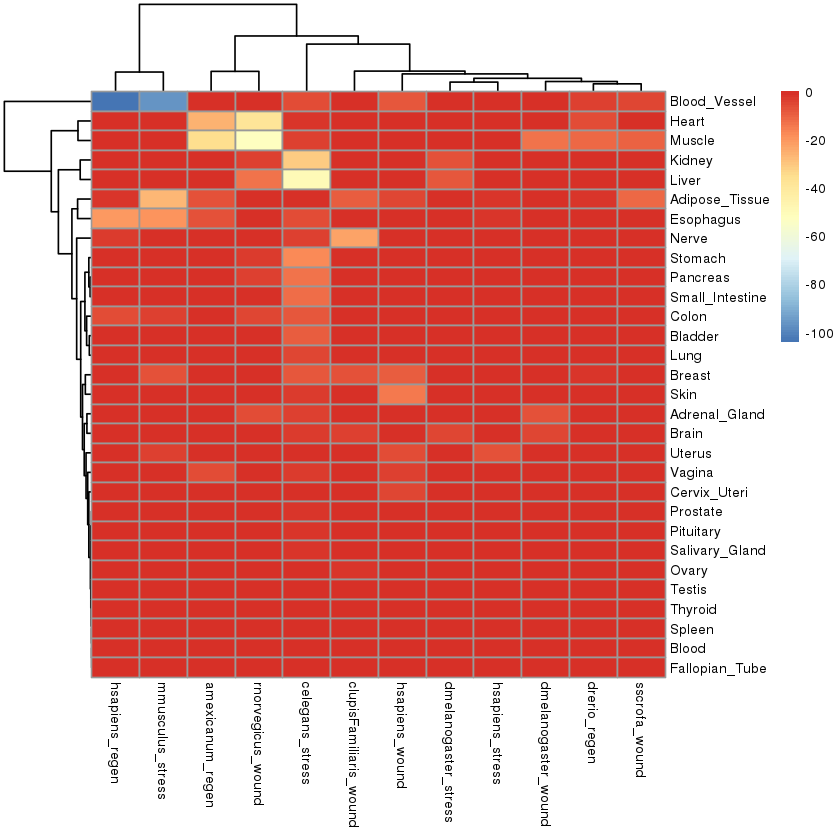

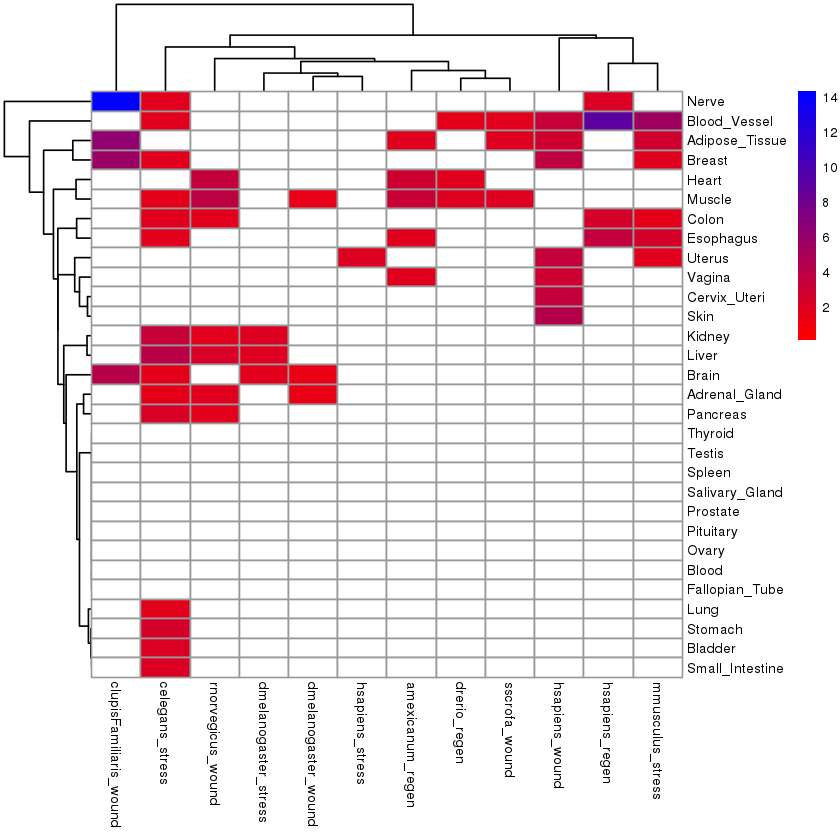

In [79]:
spec_exp_tissue_type_up_reccurent <- get_enrichment_data(non_zero_reccurent_up,tissue_types)
spec_exp_tissue_type_up_reccurent_new <- change_matrix(spec_exp_tissue_type_up_reccurent$matrix,
                                                       spec_exp_tissue_type_up_reccurent$odds_matrix)

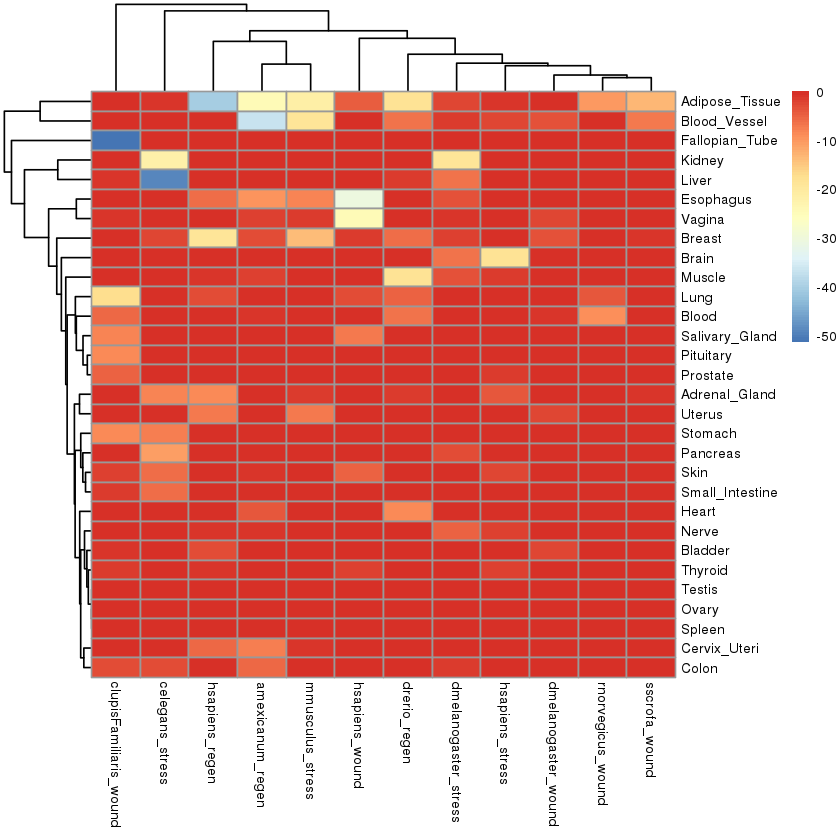

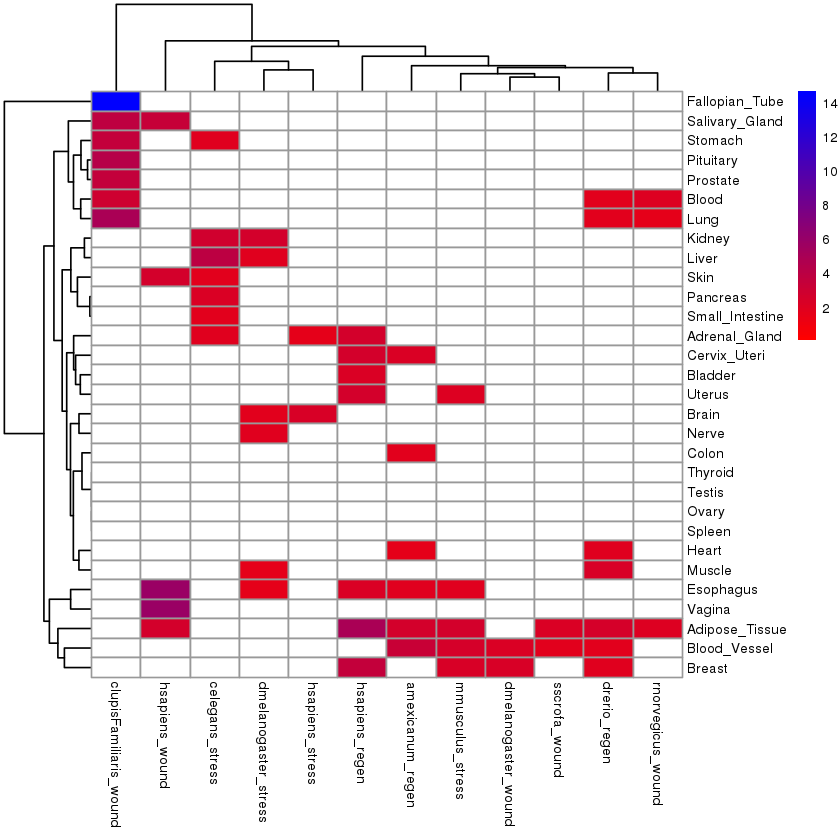

In [80]:
spec_exp_tissue_type_down_reccurent <- get_enrichment_data(non_zero_reccurent_down,tissue_types)
spec_exp_tissue_type_down_reccurent_new <- change_matrix(spec_exp_tissue_type_down_reccurent$matrix,
                                                       spec_exp_tissue_type_down_reccurent$odds_matrix)

In [81]:
similar<-c(15,36,43,21,22,33,34,20)
similar2<- c(54,55,56,53,51,52,49)
rownames(regen_up_simsem)[similar]
rownames(regen_up_simsem)[similar2]

ERROR: Error in rownames(regen_up_simsem): object 'regen_up_simsem' not found


In [ ]:
rownames(regen_up_simsem)[regen_all$tree_row$order]